In [1]:
## RASDS (RAS Dependency Score)
options(repr.plot.width=7, repr.plot.height=7)

In [2]:
library(SummarizedExperiment)
library(corrplot)
library(survival)
library(survminer)
source("R/RASDS.R")

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Loading required package: S4Vecto

In [3]:
sessionInfo()

R version 4.0.0 (2020-04-24)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Catalina 10.15.5

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRblas.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRlapack.dylib

locale:
[1] en_CA.UTF-8/en_CA.UTF-8/en_CA.UTF-8/C/en_CA.UTF-8/en_CA.UTF-8

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] survminer_0.4.7             ggpubr_0.3.0               
 [3] ggplot2_3.3.1               survival_3.2-3             
 [5] corrplot_0.84               SummarizedExperiment_1.18.1
 [7] DelayedArray_0.14.0         matrixStats_0.56.0         
 [9] Biobase_2.48.0              GenomicRanges_1.40.0       
[11] GenomeInfoDb_1.24.2         IRanges_2.22.2             
[13] S4Vectors_0.26.1            BiocGenerics_0.34.0        

loaded via a namespace (and not attached):
 [1

In [4]:
##### ##### ##### ##### ##### #####
## Patient-derived organoids
pdo <- readRDS("data/PMLB-PDO.rds")
pdoData <- transExp(assays(pdo)$exprs+1)

In [5]:
rownames(pdoData)[which(rownames(pdoData) == "KDF1")] <- "C1orf172"
rownames(pdoData)[which(rownames(pdoData) == "ADGRF4")] <- "GPR115"
rownames(pdoData)[which(rownames(pdoData) == "AOC1")] <- "ABP1"
rownames(pdoData)[which(rownames(pdoData) == "MIR4435-2HG")] <- "LOC541471"

In [6]:
pdoResults <- calcScores(pdoData)
pdoResults$gem = as.numeric(colData(pdo)$GEM)
pdoResults$tra = as.numeric(colData(pdo)$TRA)

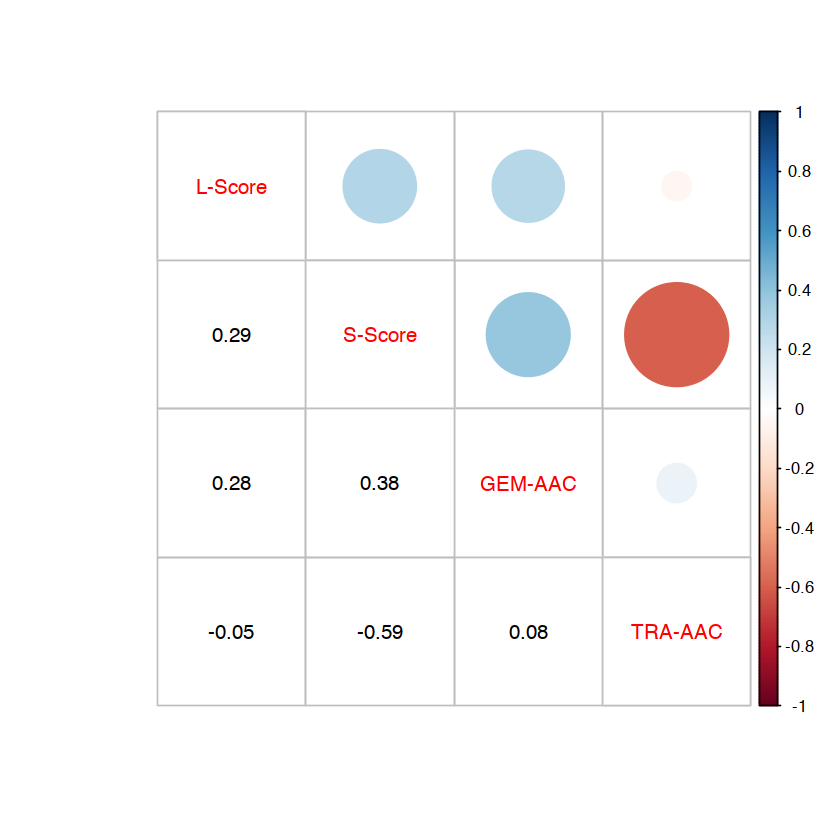

In [7]:
corPdoResults <- cor(pdoResults[,c(2:5)], use="complete.obs", method="spearman")
rownames(corPdoResults) <- c("L-Score", "S-Score", "GEM-AAC", "TRA-AAC")
colnames(corPdoResults) <- c("L-Score", "S-Score", "GEM-AAC", "TRA-AAC")
corrplot.mixed(corPdoResults, lower.col = "black")

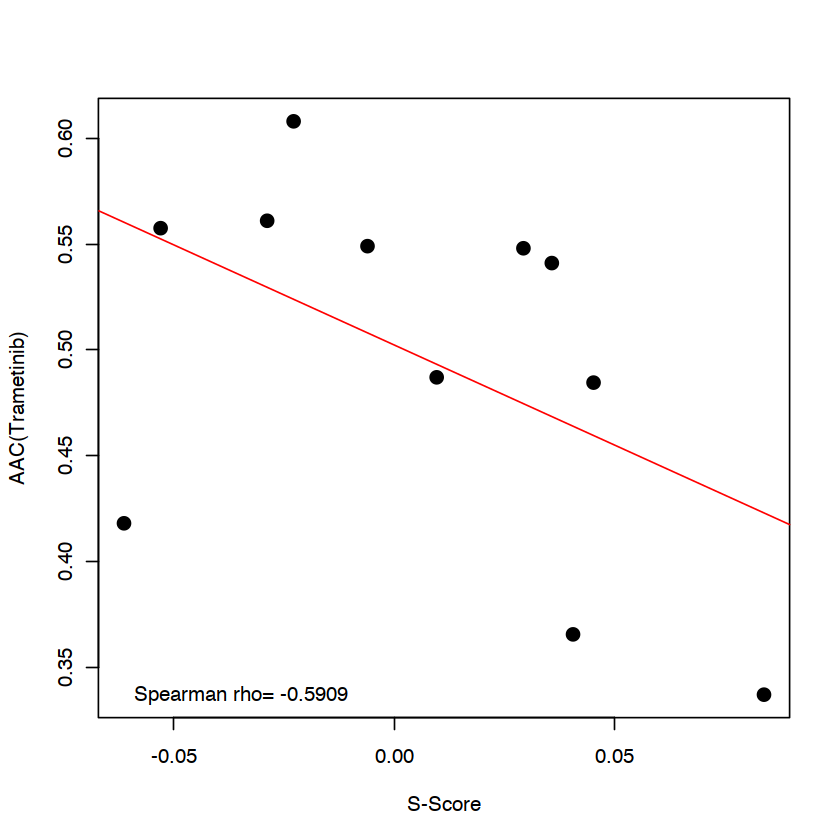

In [8]:
cor_coef <- cor(pdoResults$sscore, pdoResults$tra, use="complete.obs", method="spearman")
plot(pdoResults$sscore, pdoResults$tra, xlab="S-Score", ylab="AAC(Trametinib)", pch=20, cex=2)
abline(lm(tra ~ sscore, data=pdoResults), col="red")
legend("bottomleft", legend=paste0("Spearman rho= ", format(round(cor_coef, 4), nsmall = 4)), bty="n")

In [9]:
##### ##### ##### ##### ##### #####
## Resected cases
metaGxPancreas <- readRDS("data/metaGxPancreas.rds")
names(metaGxPancreas)

[1] "BADEA"          "BALAGURANATHAN" "BAUER"          "CHEN"          
 [5] "COLLISSON"      "GRUTZMANN"      "HAIDER"         "HAMIDI"        
 [9] "ICGCMICRO"      "ICGCSEQ"        "JANKY"          "KIRBY"         
[13] "LUNARDI"        "OUH"            "PCSI"           "PEI"           
[17] "TCGA"           "UNC"            "WINTER"         "YANG"          
[21] "ZHANG"

In [10]:
# PCSI, resected cases
label <- "PCSI"
pcsi <- metaGxPancreas$PCSI
pcsiRawTPM <- 2^assays(pcsi)$exprs
pcsiData <- transExp(pcsiRawTPM)

In [11]:
rownames(pcsiData)[which(rownames(pcsiData) == "KDF1")] <- "C1orf172"
rownames(pcsiData)[which(rownames(pcsiData) == "ADGRF4")] <- "GPR115"
rownames(pcsiData)[which(rownames(pcsiData) == "AOC1")] <- "ABP1"
rownames(pcsiData)[which(rownames(pcsiData) == "MIR4435-2HG")] <- "LOC541471"

In [12]:
pcsiResults <- calcScores(pcsiData)
pcsiResults$time = colData(pcsi)$days_to_death
pcsiResults$vital_status = colData(pcsi)$vital_status

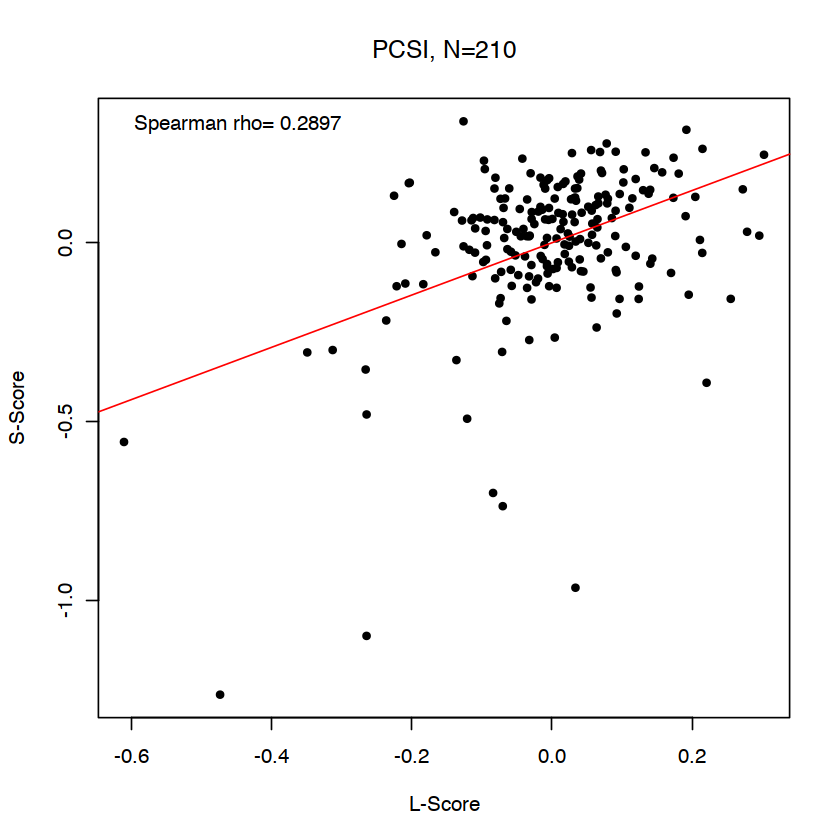

In [13]:
scatterPlot(pcsiResults, label=label)

In [14]:
pcsiResults <- pcsiResults[which(!is.na(pcsiResults$time)),]
pcsiResults$status <- TRUE # = death
pcsiResults$status[which(pcsiResults$vital_status == "living")] <- FALSE

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


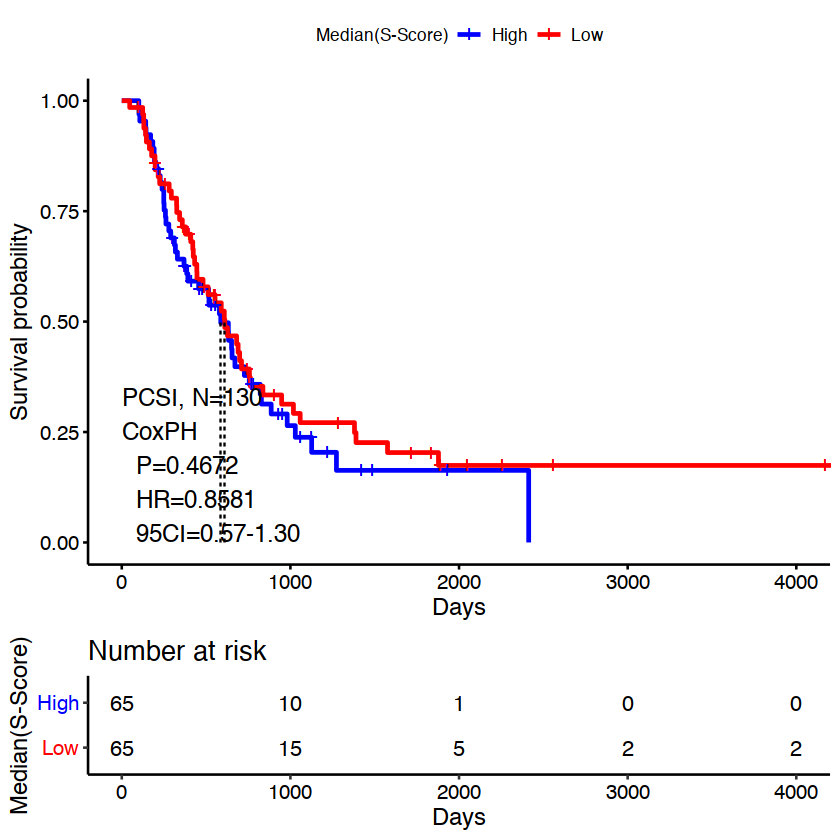

In [15]:
survivalAnalysis(pcsiResults, label, "S-Score")

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


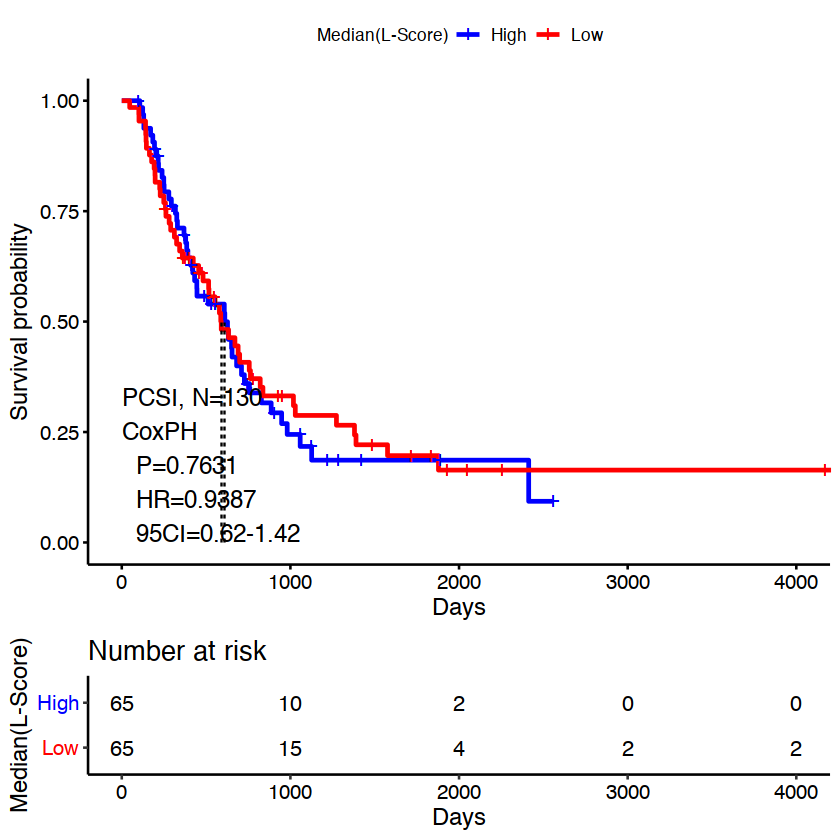

In [16]:
survivalAnalysis(pcsiResults, label, "L-Score")

In [17]:
# TCGA-PAAD, high-purity samples
label <- "TCGA-PAAD, High Purity"
tcga <- metaGxPancreas$TCGA
tcgaRawTPM <- 2^assays(tcga)$exprs

In [18]:
highPuritySamples <- c( # purity > 0.33
"TCGA.2J.AAB1", "TCGA.2J.AAB6", "TCGA.2J.AABA", "TCGA.2J.AABE",
"TCGA.2J.AABH", "TCGA.2J.AABI", "TCGA.2J.AABU", "TCGA.2L.AAQA",
"TCGA.2L.AAQE", "TCGA.2L.AAQJ", "TCGA.2L.AAQL", "TCGA.3A.A9I5",
"TCGA.3A.A9IB", "TCGA.3A.A9IC", "TCGA.3A.A9IH", "TCGA.3A.A9IU",
"TCGA.3A.A9IZ", "TCGA.3A.A9J0", "TCGA.3E.AAAZ", "TCGA.F2.6879",
"TCGA.F2.A8YN", "TCGA.FB.A545", "TCGA.FB.A78T", "TCGA.FB.AAPQ",
"TCGA.FB.AAPS", "TCGA.FB.AAPU", "TCGA.FB.AAPZ", "TCGA.FB.AAQ0",
"TCGA.FB.AAQ1", "TCGA.FB.AAQ2", "TCGA.FB.AAQ3", "TCGA.FB.AAQ6",
"TCGA.H6.8124", "TCGA.HV.A5A3", "TCGA.HV.A5A4", "TCGA.HV.A5A6",
"TCGA.HV.A7OL", "TCGA.HV.AA8X", "TCGA.HZ.7919", "TCGA.HZ.7922",
"TCGA.HZ.8005", "TCGA.HZ.8317", "TCGA.HZ.8636", "TCGA.HZ.A49I",
"TCGA.HZ.A77O", "TCGA.HZ.A8P0", "TCGA.HZ.A8P1", "TCGA.HZ.A9TJ",
"TCGA.IB.7644", "TCGA.IB.7652", "TCGA.IB.7886", "TCGA.IB.7890",
"TCGA.IB.8127", "TCGA.IB.A5SP", "TCGA.IB.A5SS", "TCGA.IB.A6UF",
"TCGA.IB.A7LX", "TCGA.IB.A7M4", "TCGA.IB.AAUN", "TCGA.IB.AAUO",
"TCGA.IB.AAUU", "TCGA.LB.A7SX", "TCGA.LB.A8F3", "TCGA.M8.A5N4",
"TCGA.OE.A75W", "TCGA.PZ.A5RE", "TCGA.Q3.AA2A", "TCGA.S4.A8RM",
"TCGA.S4.A8RO", "TCGA.S4.A8RP", "TCGA.US.A776", "TCGA.US.A779",
"TCGA.US.A77E", "TCGA.US.A77G", "TCGA.XD.AAUL", "TCGA.YY.A8LH")

In [19]:
tcgaRawTPMHighPurity <- tcgaRawTPM[,which(colnames(tcgaRawTPM) %in% highPuritySamples)]
tcgaData <- transExp(tcgaRawTPMHighPurity)

In [20]:
rownames(tcgaData)[which(rownames(tcgaData) == "IL8")] <- "CXCL8"
rownames(tcgaData)[which(rownames(tcgaData) == "C19orf10")] <- "MYDGF"
rownames(tcgaData)[which(rownames(tcgaData) == "C1orf96")] <- "CCSAP"
rownames(tcgaData)[which(rownames(tcgaData) == "C6orf182")] <- "CEP57L1"
rownames(tcgaData)[which(rownames(tcgaData) == "SF4")] <- "SUGP1"
rownames(tcgaData)[which(rownames(tcgaData) == "ALS2CR4")] <- "TMEM237"

In [21]:
tcgaResults <- calcScores(tcgaData)
tcgaResults$time = colData(tcga)$days_to_death[which(rownames(colData(tcga)) %in% highPuritySamples)]
tcgaResults$vital_status = colData(tcga)$vital_status[which(rownames(colData(tcga)) %in% highPuritySamples)]
tcgaResults$status <- TRUE # = death
tcgaResults$status[which(tcgaResults$vital_status == "living")] <- FALSE

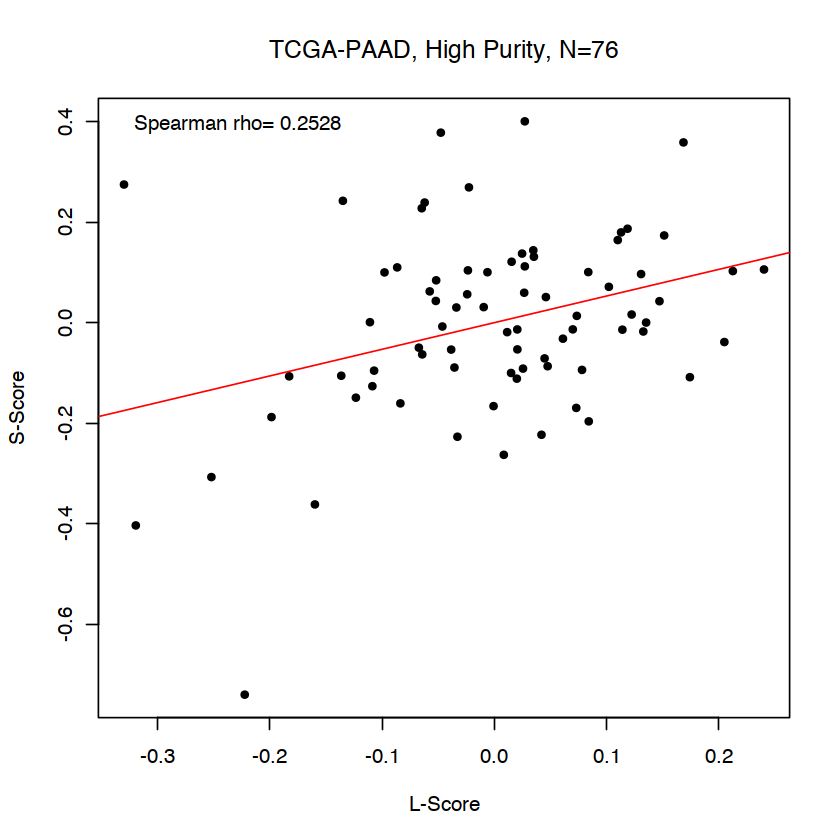

In [22]:
scatterPlot(tcgaResults, label=label)

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


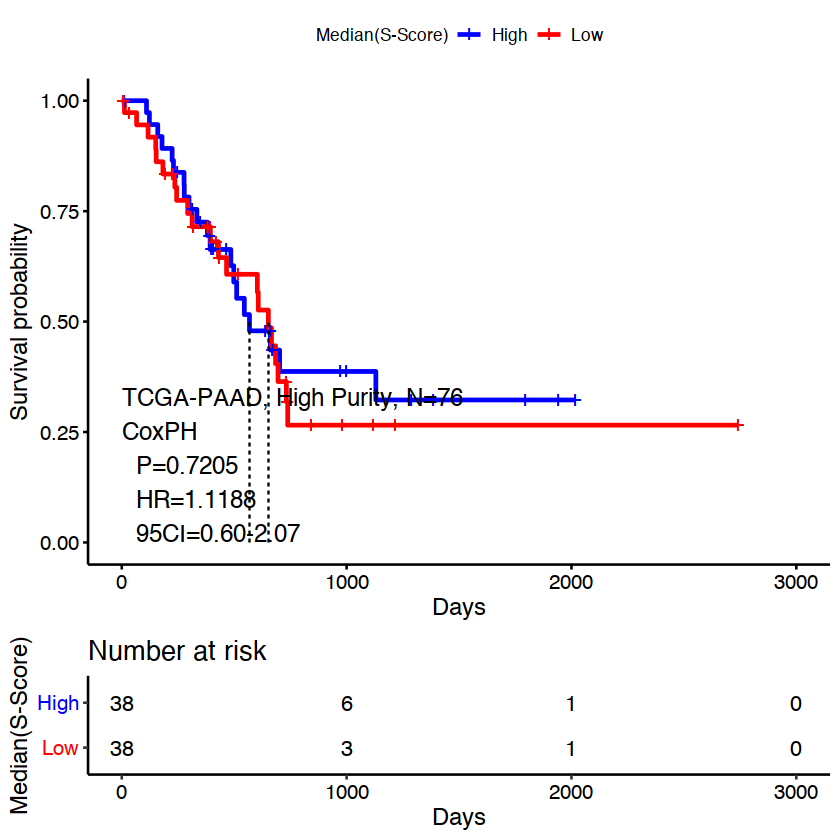

In [23]:
survivalAnalysis(tcgaResults, label, "S-Score")

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


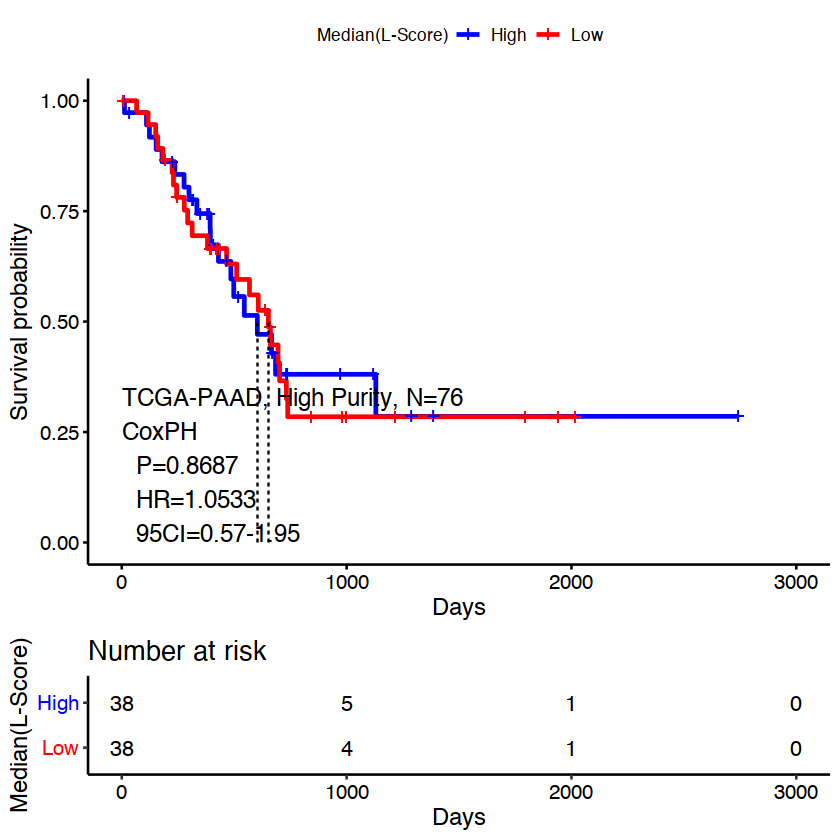

In [24]:
survivalAnalysis(tcgaResults, label, "L-Score")

In [25]:
# ICGC, AU
label <- "ICGC"
icgc <- metaGxPancreas$ICGCSEQ
icgcRawTPM <- 2^assays(icgc)$exprs
icgcData <- transExp(icgcRawTPM)

In [26]:
rownames(icgcData)[which(rownames(icgcData) == "KDF1")] <- "C1orf172"
rownames(icgcData)[which(rownames(icgcData) == "ADGRF4")] <- "GPR115"
rownames(icgcData)[which(rownames(icgcData) == "AOC1")] <- "ABP1"

exclude <- c("SLC16A3", "DRD4", "RASL10B", "RAB11FIP4", "LIX1L", "LOC541471")

In [27]:
icgcResults <- calcScores(icgcData, exclude)
icgcResults$time = colData(icgc)$days_to_death
icgcResults$vital_status = colData(icgc)$vital_status
icgcResults$status <- TRUE # = death
icgcResults$status[which(icgcResults$vital_status == "living")] <- FALSE

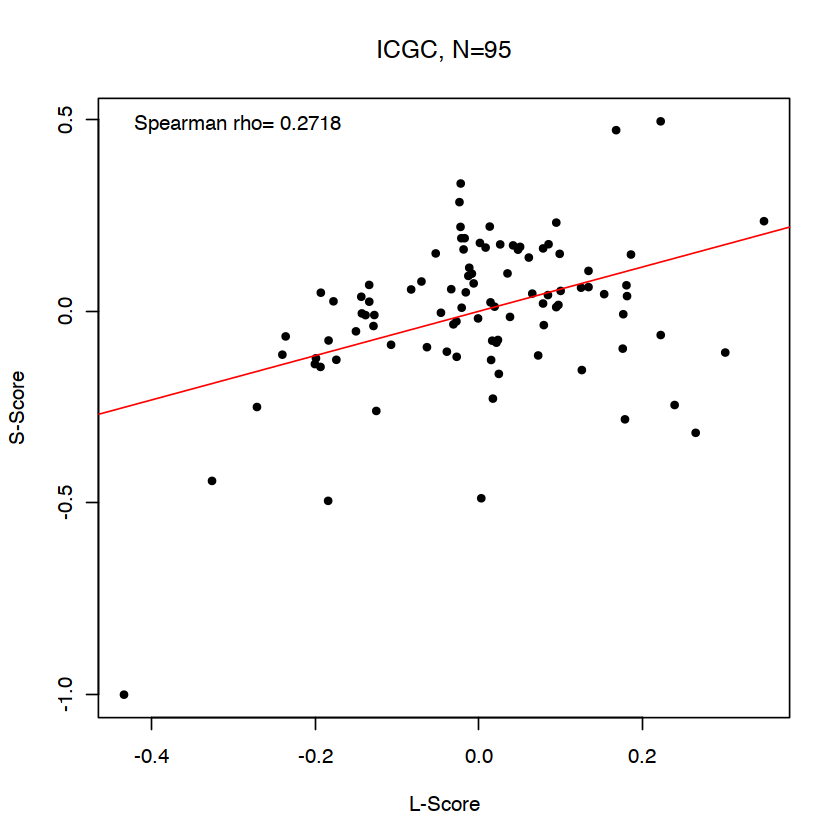

In [28]:
scatterPlot(icgcResults, label=label)

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


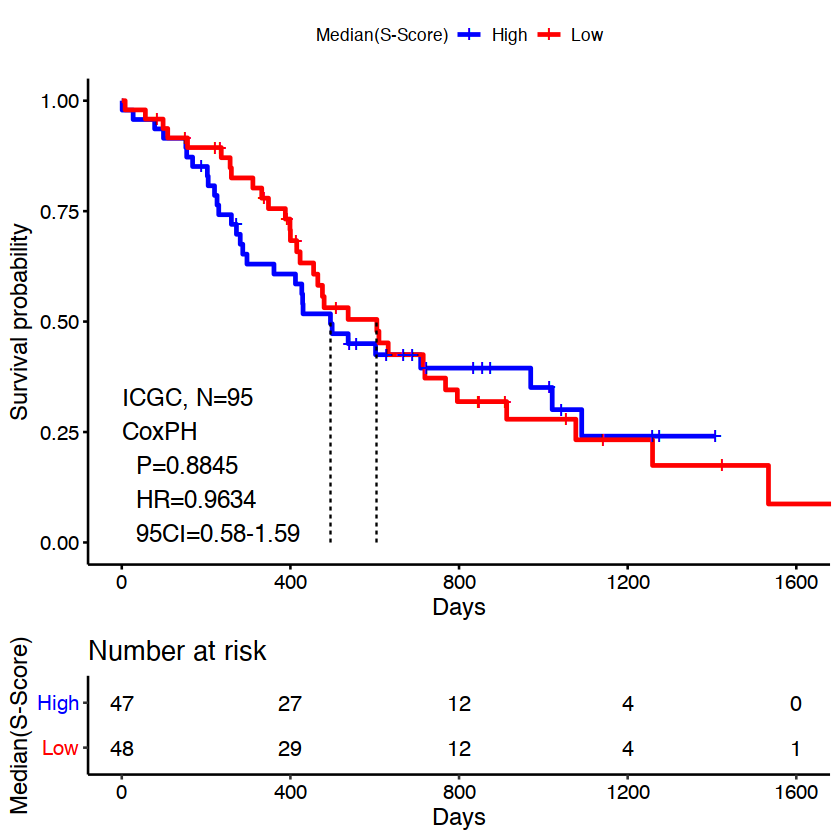

In [29]:
survivalAnalysis(icgcResults, label, "S-Score")

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


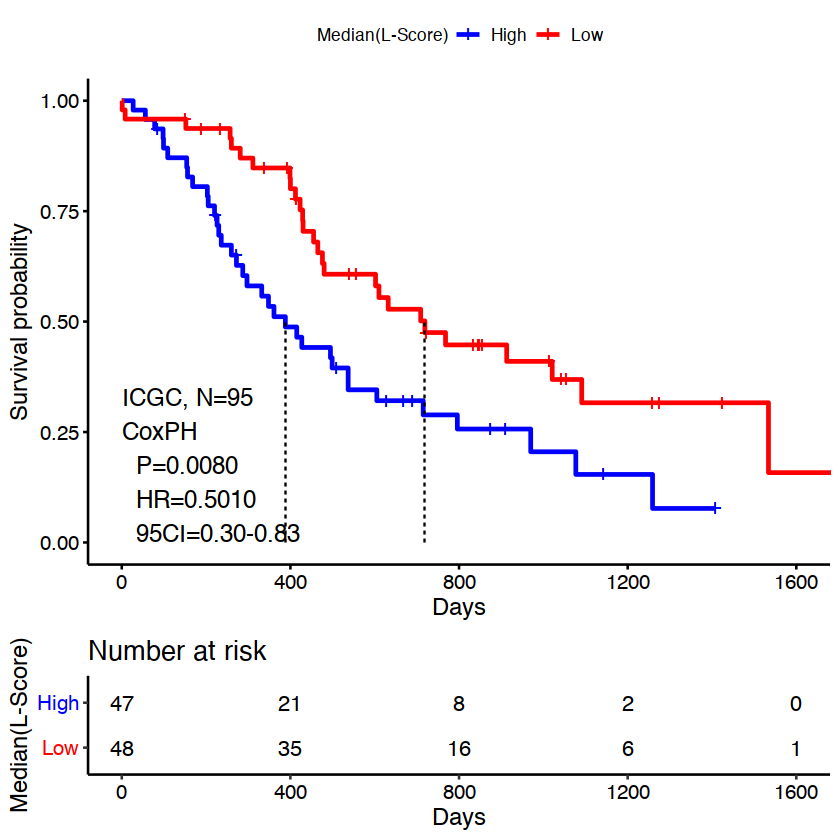

In [30]:
survivalAnalysis(icgcResults, label, "L-Score")

In [31]:
# KIRBY et al.
label <- "KIRBY"
kirby <- metaGxPancreas$KIRBY
kirbyRawTPM <- 2^assays(kirby)$exprs
kirbyData <- transExp(kirbyRawTPM)

In [32]:
rownames(kirbyData)[which(rownames(kirbyData) == "IL8")] <- "CXCL8"
rownames(kirbyData)[which(rownames(kirbyData) == "C19orf10")] <- "MYDGF"
rownames(kirbyData)[which(rownames(kirbyData) == "AOC1")] <- "ABP1"

exclude <- c("LIX1L", "LOC541471")

In [33]:
kirbyResults <- calcScores(kirbyData, exclude)
kirbyResults$time = colData(kirby)$days_to_death
kirbyResults$vital_status = colData(kirby)$vital_status
kirbyResults$status <- TRUE # = death
kirbyResults$status[which(kirbyResults$vital_status == "living")] <- FALSE

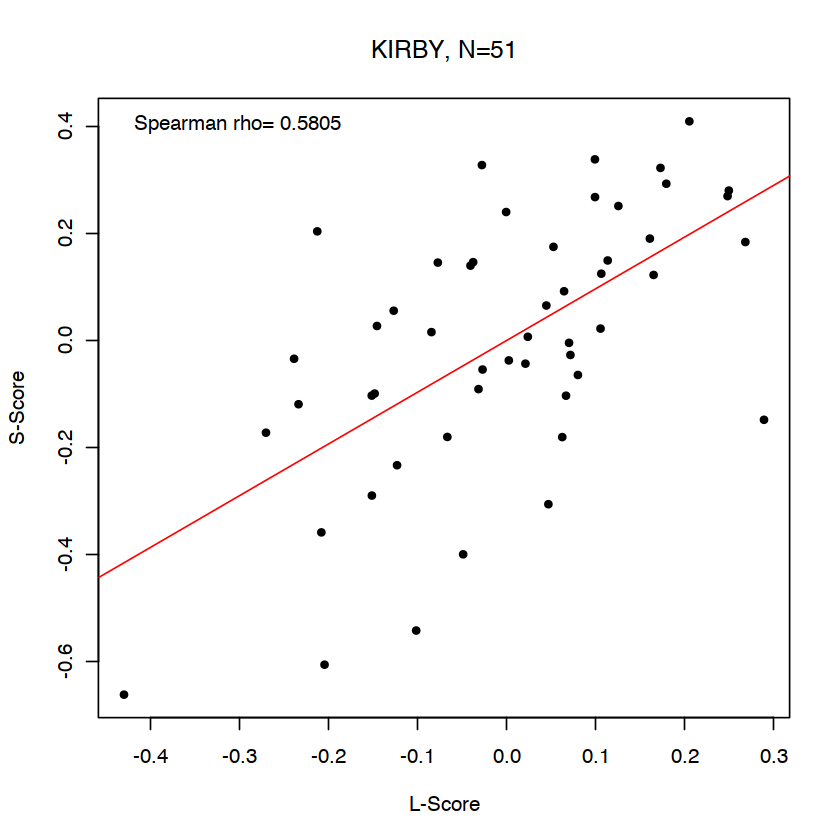

In [34]:
scatterPlot(kirbyResults, label=label)

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


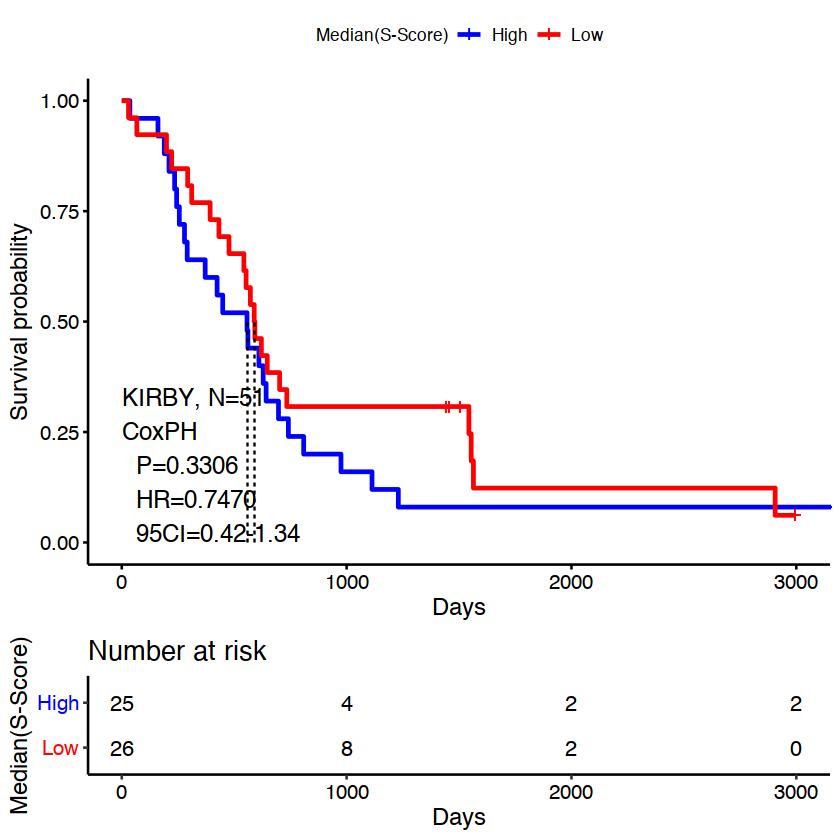

In [35]:
survivalAnalysis(kirbyResults, label, "S-Score")

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


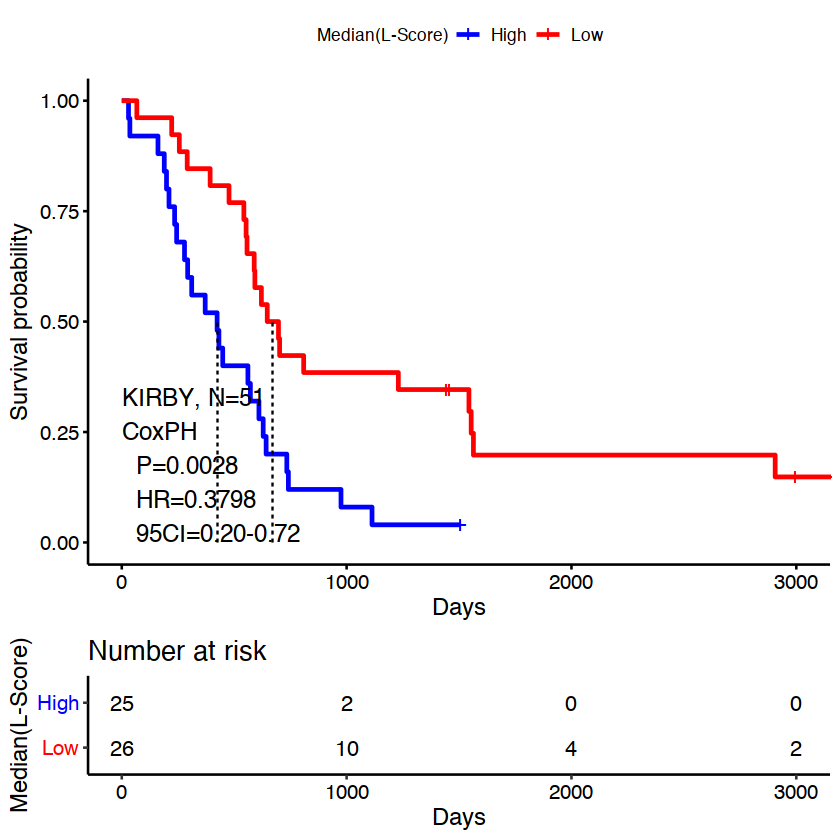

In [36]:
survivalAnalysis(kirbyResults, label, "L-Score")

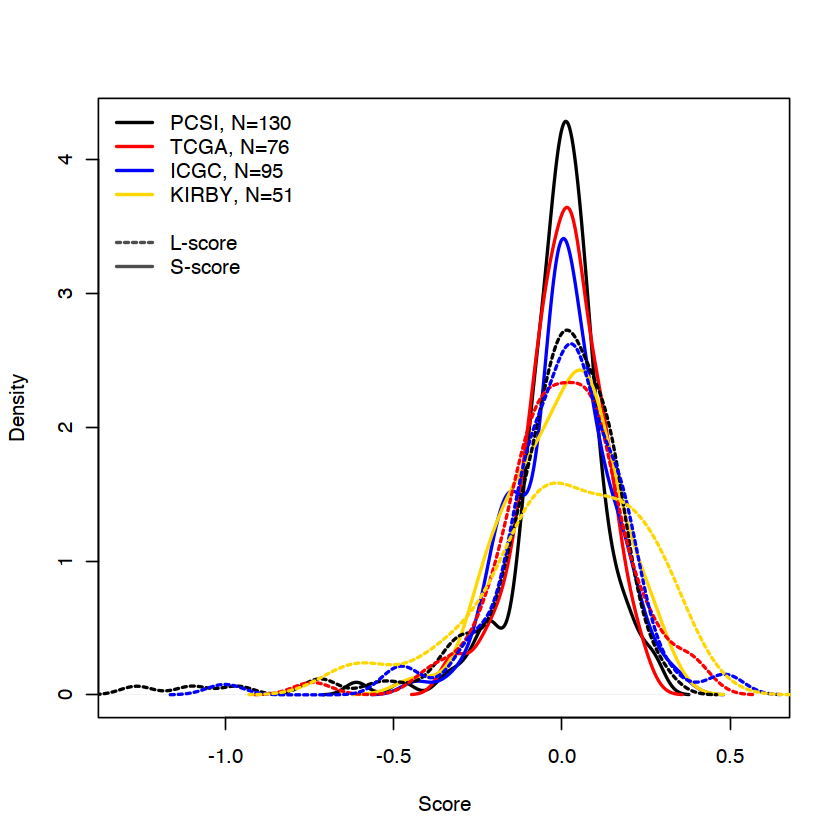

In [37]:
plot(density(as.numeric(pcsiResults$lscore)), xlim=c(-1.3, 0.6), main="", xlab="Score", col="black", lwd=2)
lines(density(as.numeric(tcgaResults$lscore)), col="red", lwd=2)
lines(density(as.numeric(icgcResults$lscore)), col="blue", lwd=2)
lines(density(as.numeric(kirbyResults$lscore)), col="gold", lwd=2)

lines(density(as.numeric(pcsiResults$sscore)), col="black", lty=2, lwd=2)
lines(density(as.numeric(tcgaResults$sscore)), col="red", lty=2, lwd=2)
lines(density(as.numeric(icgcResults$sscore)), col="blue", lty=2, lwd=2)
lines(density(as.numeric(kirbyResults$sscore)), col="gold", lty=2, lwd=2)

legend("topleft",
    legend=c("PCSI, N=130", "TCGA, N=76", "ICGC, N=95", "KIRBY, N=51", NA, "L-score", "S-score"),
    lty=c(1,1,1,1,1,2), lwd=2, col=c("black", "red", "blue", "gold", NA, rep("grey30", 2)),
    ncol=1, bty="n")

In [38]:
##### ##### ##### ##### ##### #####
## Advanced cases (COMPASS)
label <- "COMPASS"
compass <- readRDS("data/COMPASS.rds")
compassRawTPM <- 2^assays(compass)$exprs
compassData <- transExp(compassRawTPM)

In [39]:
rownames(compassData)[which(rownames(compassData) == "KDF1")] <- "C1orf172"
rownames(compassData)[which(rownames(compassData) == "ADGRF4")] <- "GPR115"
rownames(compassData)[which(rownames(compassData) == "AOC1")] <- "ABP1"
rownames(compassData)[which(rownames(compassData) == "MIR4435-2HG")] <- "LOC541471"

In [40]:
compassResults <- calcScores(compassData)

moffitt_color <- rep("blue", nrow(compassResults))
moffitt_color[which(colData(compass)$Moffitt == "basal-like")] <- "gold"

KRAS_mut <- colData(compass)$allele
KRAS_mut[which(is.na(KRAS_mut))] <- "WT"
KRAS_mut_factor <- as.factor(KRAS_mut)

treatments <- colData(compass)$drug
treatments[which(is.na(treatments))] <- "N/A"
treatments[which(treatments == "None")] <- "N/A"
treatments[which(treatments == "FFx-GA")] <- "N/A"
treatments[which(treatments == "GA-FFx")] <- "N/A"
treatments[which(treatments == "GA-gem")] <- "GA"
treatments[which(treatments == "GA-IO")] <- "GA"
treatments[which(treatments == "Gem-only")] <- "GA"
treatments[which(treatments == "GA(PA7)")] <- "GA"
treatments[which(treatments == "GA+BBI")] <- "GA"
treatments[which(treatments == "PA7-GA")] <- "GA"
treatments[which(treatments == "FFx+5FU")] <- "FFx"
treatments <- as.factor(treatments)

responses <- colData(compass)$tumorResponse
responses_color <- rep("black", length(responses))
responses_color[is.na(responses)] <- "grey40"
responses_color[which(responses > 20)] <- "blue"
responses_color[which(responses < -30)] <- "red"

kras_idx <- which(rownames(assays(compass)$exprs) == "KRAS")
nras_idx <- which(rownames(assays(compass)$exprs) == "NRAS")
hras_idx <- which(rownames(assays(compass)$exprs) == "HRAS")
braf_idx <- which(rownames(assays(compass)$exprs) == "BRAF")
brca1_idx <- which(rownames(assays(compass)$exprs) == "BRCA1")
brca2_idx <- which(rownames(assays(compass)$exprs) == "BRCA2")

compassResults$color <- moffitt_color
compassResults$kras_mut <- KRAS_mut_factor
compassResults$kras_expr <- assays(compass)$exprs[kras_idx,]
compassResults$nras_expr <- assays(compass)$exprs[nras_idx,]
compassResults$hras_expr <- assays(compass)$exprs[hras_idx,]
compassResults$braf_expr <- assays(compass)$exprs[braf_idx,]
compassResults$brca1_expr <- assays(compass)$exprs[brca1_idx,]
compassResults$brca2_expr <- assays(compass)$exprs[brca2_idx,]
compassResults$treatments <- as.numeric(treatments)
compassResults$responses <- responses_color
compassResults$time <- colData(compass)$OS
compassResults$status <- colData(compass)$OSstatus

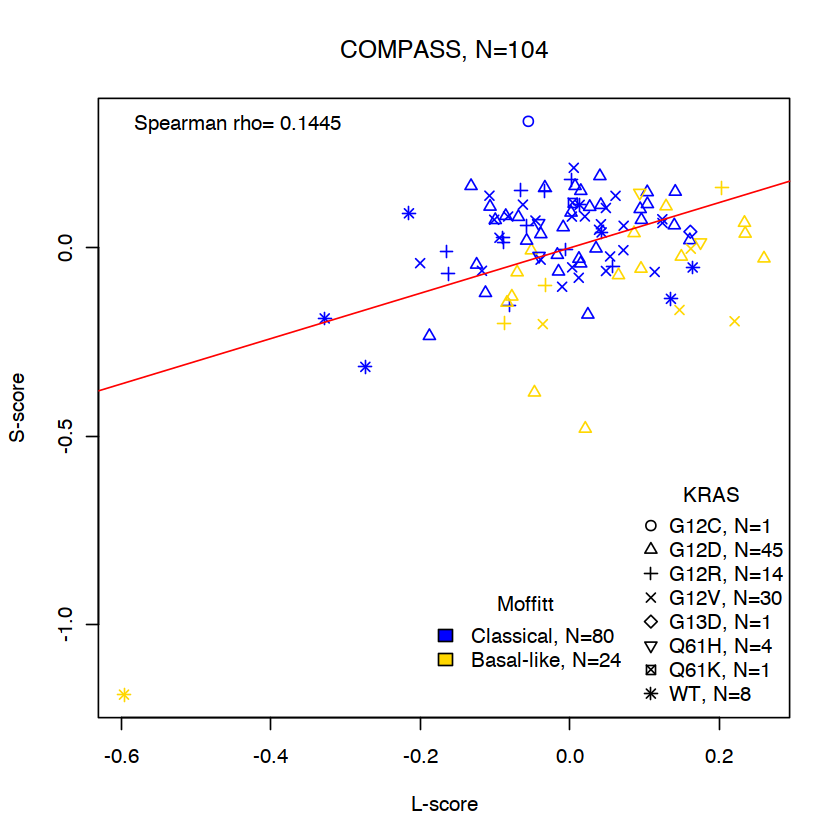

In [41]:
plot(compassResults$lscore, compassResults$sscore,
    col=compassResults$color,
    pch=as.numeric(compassResults$kras_mut),
    xlab="L-score", ylab="S-score",
    main=paste0("COMPASS, N=", nrow(compassResults)))
abline(lm(sscore ~ lscore, data= compassResults), col="red")
legend("topleft", legend=paste0("Spearman rho= ", round(cor(compassResults$lscore, compassResults$sscore, method="spearman"), 4)), bty="n")
legend("bottomright",
    legend=paste(levels(KRAS_mut_factor), table(KRAS_mut_factor), sep=", N="),
    pch=c(1:length(levels(KRAS_mut_factor))),
    bty="n", title="KRAS")
legend(-0.2, -0.9,
    legend=c("Classical, N=80", "Basal-like, N=24"),
    fill=c("blue", "gold"),
    bty="n", title="Moffitt")

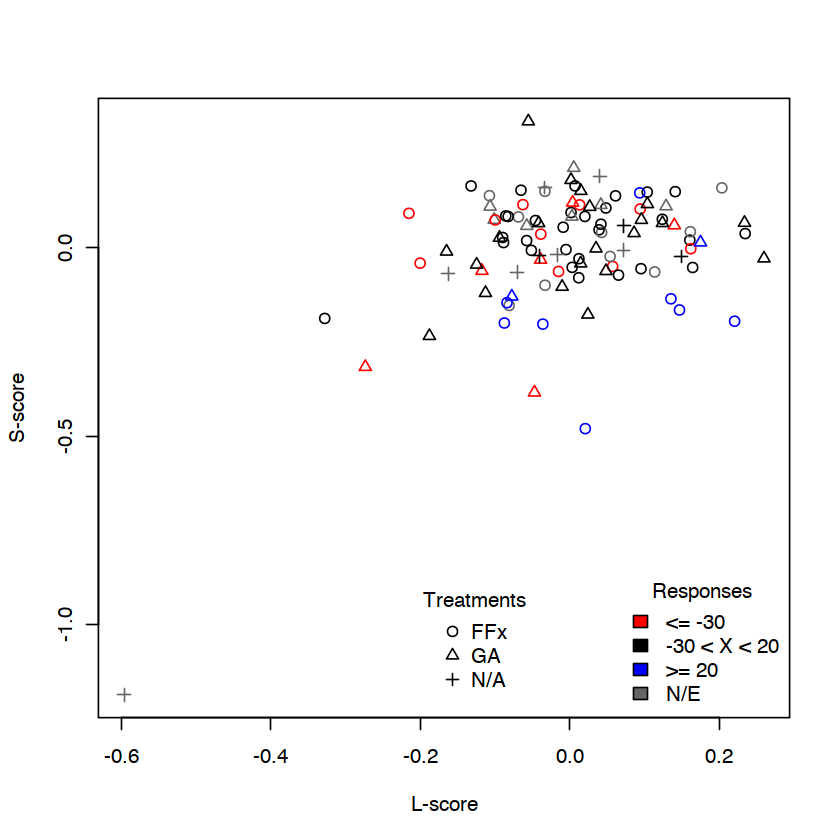

In [42]:
plot(compassResults$lscore, compassResults$sscore,
    col=compassResults$responses,
    pch=compassResults$treatments,
    xlab="L-score", ylab="S-score")
legend("bottomright",
    legend=c("<= -30", "-30 < X < 20", ">= 20", "N/E"),
    fill=c("red", "black", "blue", "grey40"),
    bty="n", title="Responses")
legend(-0.2, -0.89,
    legend=c("FFx", "GA", "N/A"),
    pch=c(1,2,3),
    col=c("black","black","black"),
    bty="n", title="Treatments")

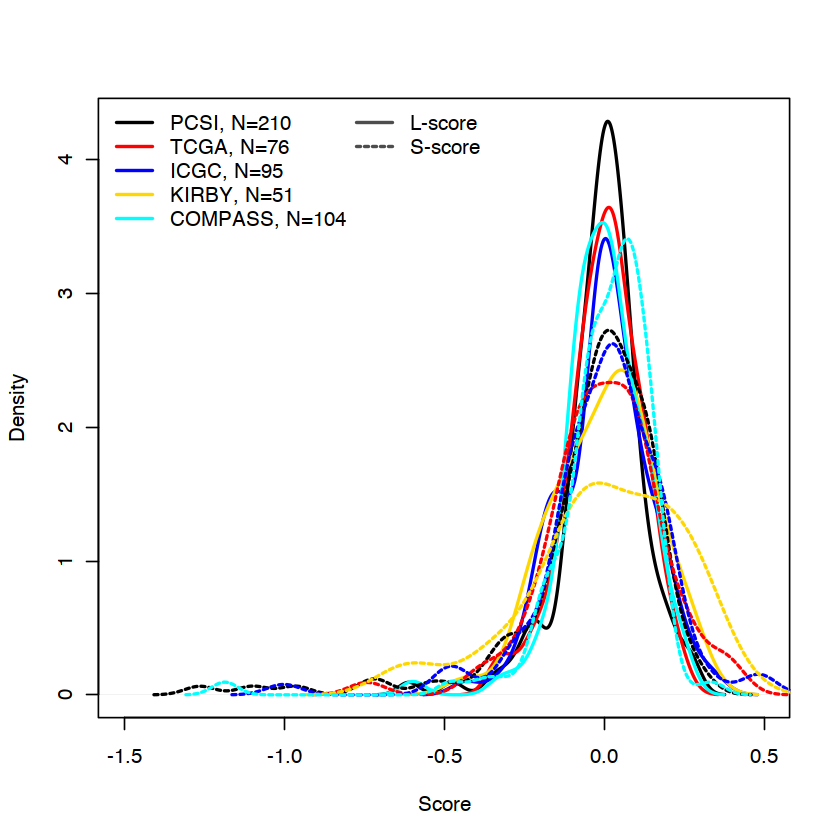

In [43]:
# Density plot across datasets
plot(density(as.numeric(pcsiResults$lscore)), xlim=c(-1.5, 0.5), main="", xlab="Score", col="black", lwd=2)
lines(density(as.numeric(tcgaResults$lscore)), col="red", lwd=2)
lines(density(as.numeric(icgcResults$lscore)), col="blue", lwd=2)
lines(density(as.numeric(kirbyResults$lscore)), col="gold", lwd=2)
lines(density(as.numeric(compassResults$lscore)), col="cyan", lwd=2)
lines(density(as.numeric(pcsiResults$sscore)), col="black", lty=2, lwd=2)
lines(density(as.numeric(tcgaResults$sscore)), col="red", lty=2, lwd=2)
lines(density(as.numeric(icgcResults$sscore)), col="blue", lty=2, lwd=2)
lines(density(as.numeric(kirbyResults$sscore)), col="gold", lty=2, lwd=2)
lines(density(as.numeric(compassResults$sscore)), col="cyan", lty=2, lwd=2)
legend("topleft",
    legend=c("PCSI, N=210", "TCGA, N=76", "ICGC, N=95", "KIRBY, N=51", "COMPASS, N=104",
             "L-score", "S-score", NA, NA, NA),
    lty=c(1,1,1,1,1,1,2, rep(NA, 3)), lwd=2,
    col=c("black", "red", "blue", "gold", "cyan", rep("grey30", 2), rep(NA, 3)),
    ncol=2, bty="n")

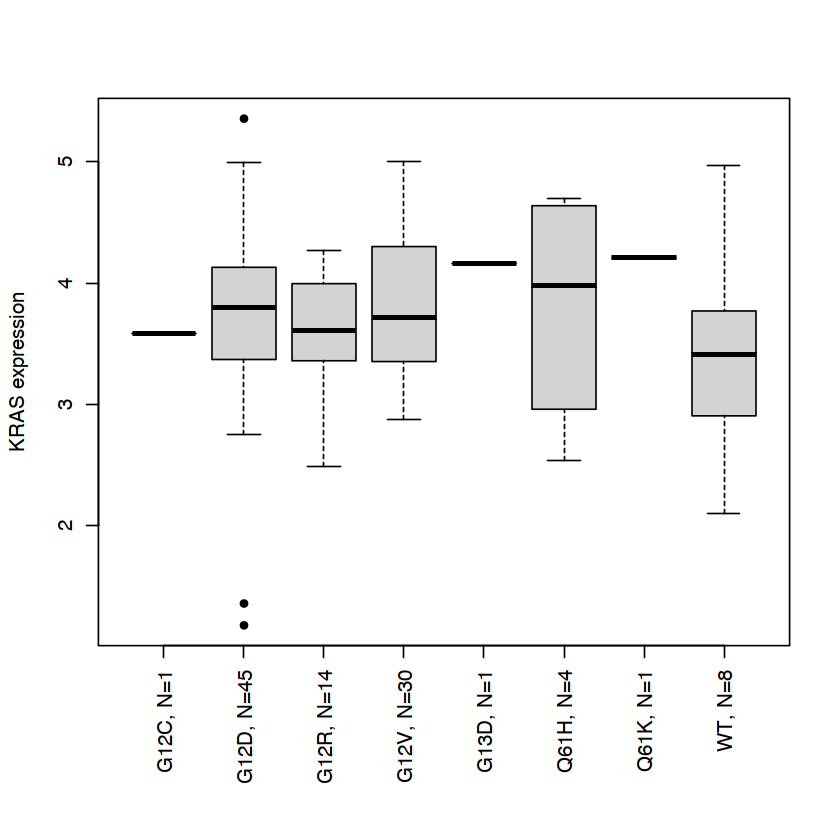

In [44]:
# ?RAS and KRAS mut.
par(oma=c(3,0,0,0))
boxplot(kras_expr ~ kras_mut, data=compassResults,
    xlab="", ylab="KRAS expression", pch=20,
    names=paste0(levels(compassResults$kras_mut), ", N=", table(compassResults$kras_mut)),
    las=3)

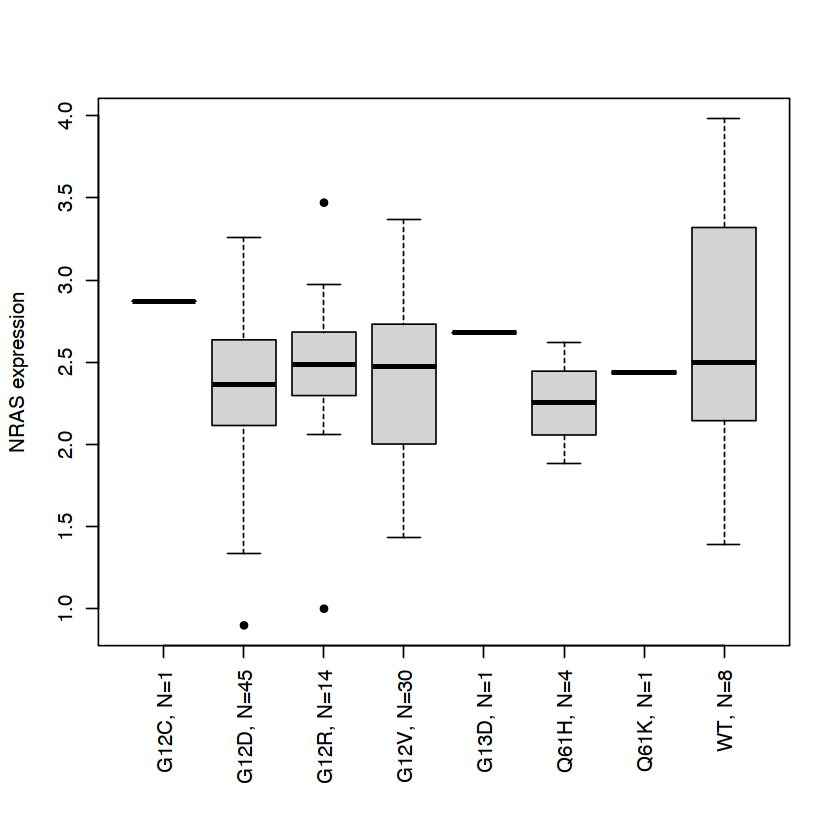

In [45]:
par(oma=c(3,0,0,0))
boxplot(nras_expr ~ kras_mut, data=compassResults,
    xlab="", ylab="NRAS expression", pch=20,
    names=paste0(levels(compassResults$kras_mut), ", N=", table(compassResults$kras_mut)),
    las=3)

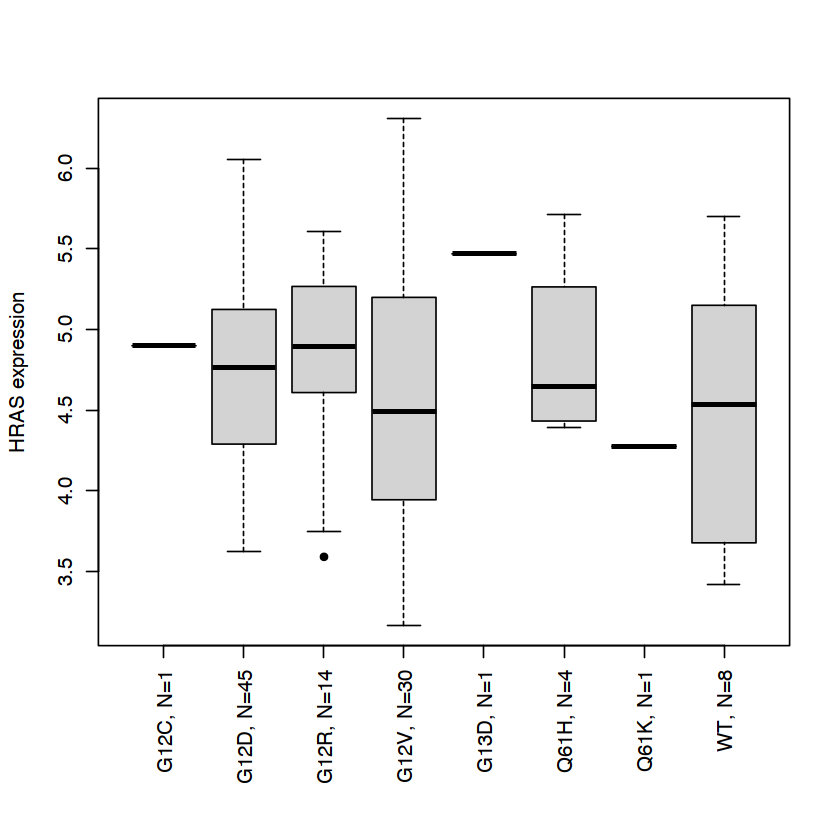

In [46]:
par(oma=c(3,0,0,0))
boxplot(hras_expr ~ kras_mut, data=compassResults,
    xlab="", ylab="HRAS expression", pch=20,
    names=paste0(levels(compassResults$kras_mut), ", N=", table(compassResults$kras_mut)),
    las=3)

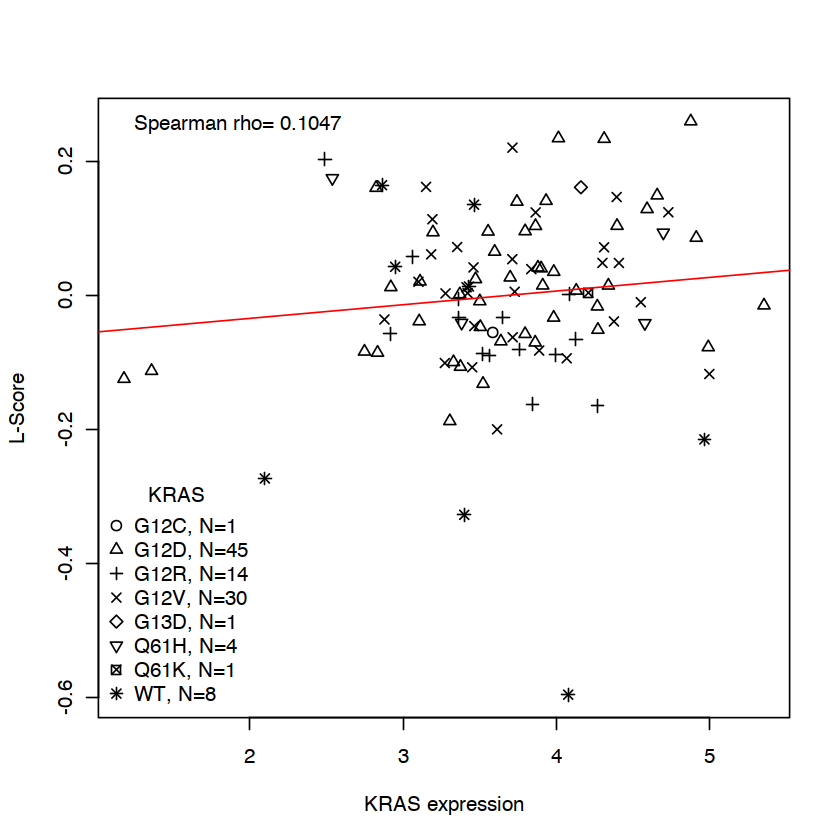

In [47]:
## KRAS exp and L-score
cor_coef <- cor(compassResults$kras_expr, compassResults$lscore, method="spearman")
plot(compassResults$kras_expr, compassResults$lscore,
    xlab="KRAS expression", ylab="L-Score",
    pch=as.numeric(compassResults$kras_mut),
)
abline(lm(lscore ~ kras_expr, data=compassResults), col="red")
legend("topleft", legend=paste0("Spearman rho= ", format(round(cor_coef, 4), nsmall = 4)), bty="n")
legend("bottomleft",
    legend=paste(levels(KRAS_mut_factor), table(KRAS_mut_factor), sep=", N="),
    pch=c(1:length(levels(KRAS_mut_factor))),
    bty="n", title="KRAS")

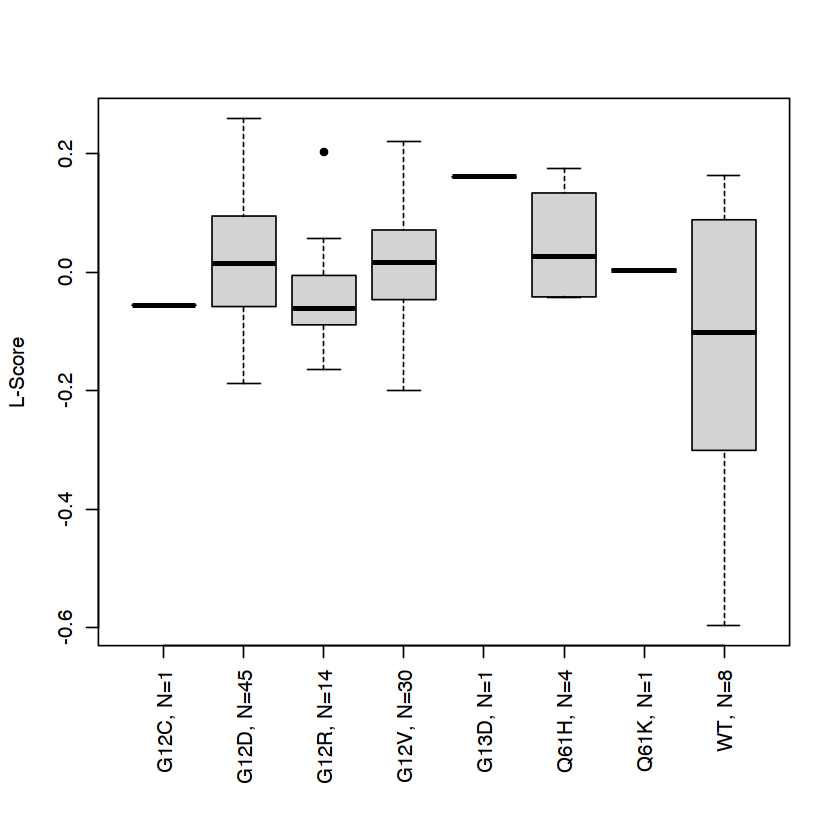

In [48]:
par(oma=c(3,0,0,0))
boxplot(lscore ~ kras_mut, data=compassResults,
    xlab="", ylab="L-Score", pch=20,
    names=paste0(levels(compassResults$kras_mut), ", N=", table(compassResults$kras_mut)),
    las=3)

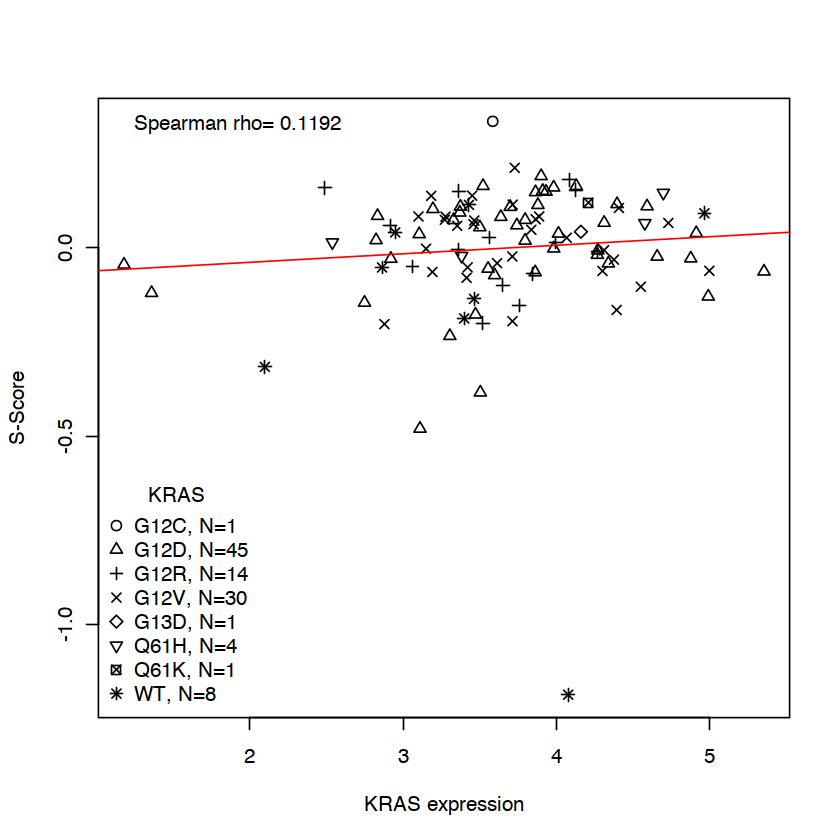

In [49]:
# KRAS exp and S-Score
cor_coef <- cor(compassResults$kras_expr, compassResults$sscore, method="spearman")
plot(compassResults$kras_expr, compassResults$sscore,
    xlab="KRAS expression", ylab="S-Score",
    pch=as.numeric(compassResults$kras_mut),
)
abline(lm(sscore ~ kras_expr, data=compassResults), col="red")
legend("topleft", legend=paste0("Spearman rho= ", format(round(cor_coef, 4), nsmall = 4)), bty="n")
legend("bottomleft",
    legend=paste(levels(KRAS_mut_factor), table(KRAS_mut_factor), sep=", N="),
    pch=c(1:length(levels(KRAS_mut_factor))),
    bty="n", title="KRAS")

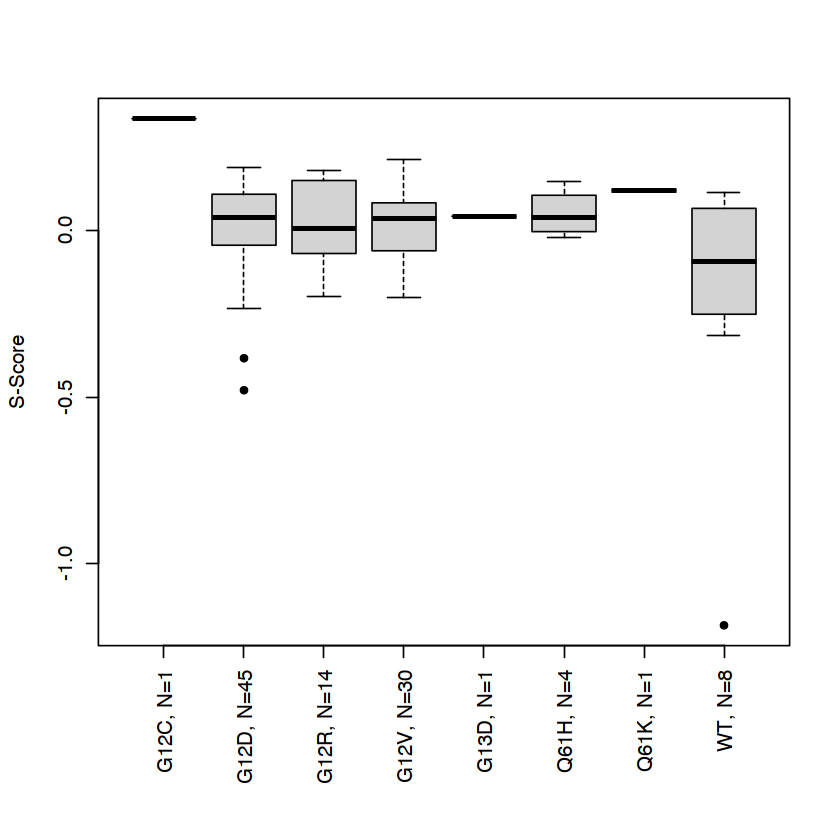

In [50]:
par(oma=c(3,0,0,0))
boxplot(sscore ~ kras_mut, data=compassResults,
    xlab="", ylab="S-Score", pch=20,
    names=paste0(levels(compassResults$kras_mut), ", N=", table(compassResults$kras_mut)),
    las=3
)

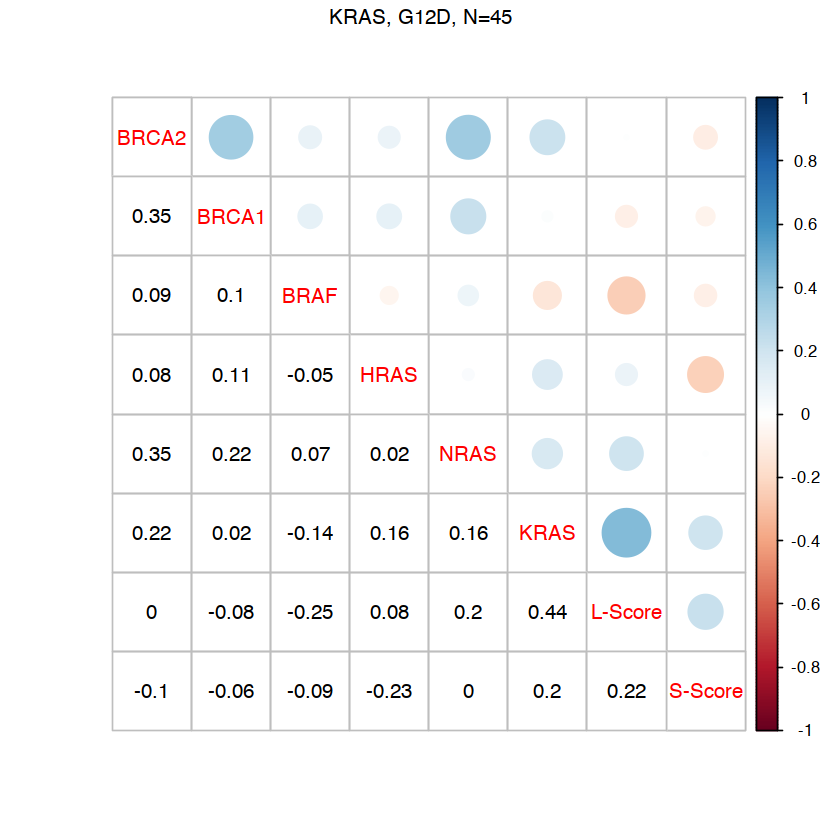

In [51]:
# Cor - HRAS, NRAS, KRAS, L-Score, and S-score
par(oma=c(0,0,0,0))
data <- compassResults[which(as.character(compassResults$kras_mut) == "G12D"),]
cor <- cor(data[,c(11,10,9,8,7,6,2,3)], method="spearman")
rownames(cor) <- c("BRCA2", "BRCA1", "BRAF", "HRAS", "NRAS", "KRAS", "L-Score", "S-Score")
colnames(cor) <- c("BRCA2", "BRCA1", "BRAF", "HRAS", "NRAS", "KRAS", "L-Score", "S-Score")
corrplot.mixed(cor, lower.col = "black")
mtext("KRAS, G12D, N=45", side=3, line=3)

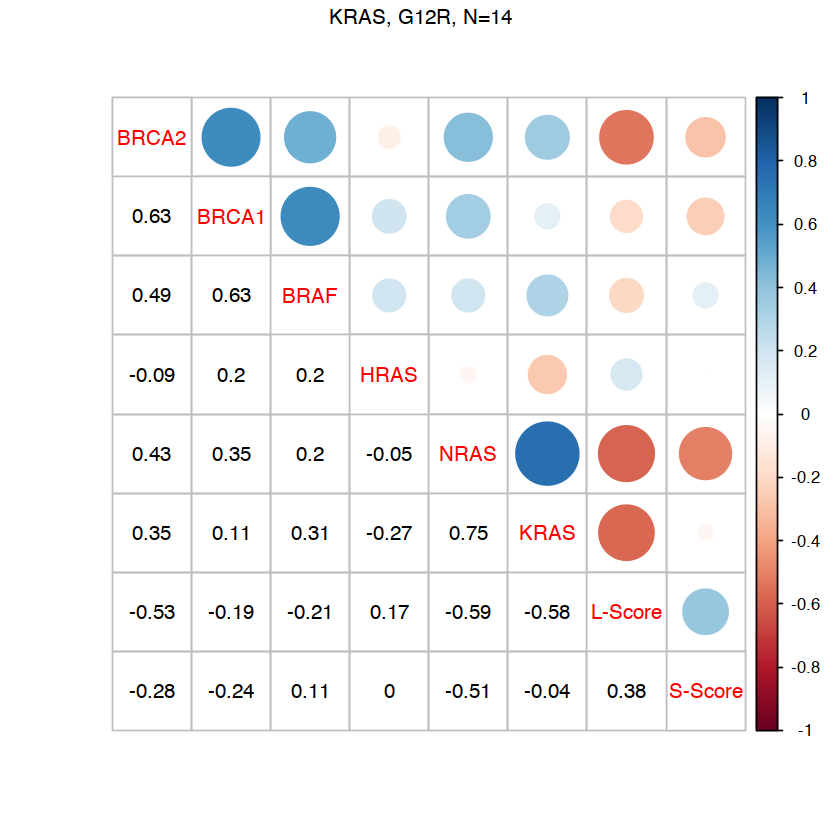

In [52]:
data <- compassResults[which(as.character(compassResults$kras_mut) == "G12R"),]
cor <- cor(data[,c(11,10,9,8,7,6,2,3)], method="spearman")
rownames(cor) <- c("BRCA2", "BRCA1", "BRAF", "HRAS", "NRAS", "KRAS", "L-Score", "S-Score")
colnames(cor) <- c("BRCA2", "BRCA1", "BRAF", "HRAS", "NRAS", "KRAS", "L-Score", "S-Score")
corrplot.mixed(cor, lower.col = "black")
mtext("KRAS, G12R, N=14", side=3, line=3)

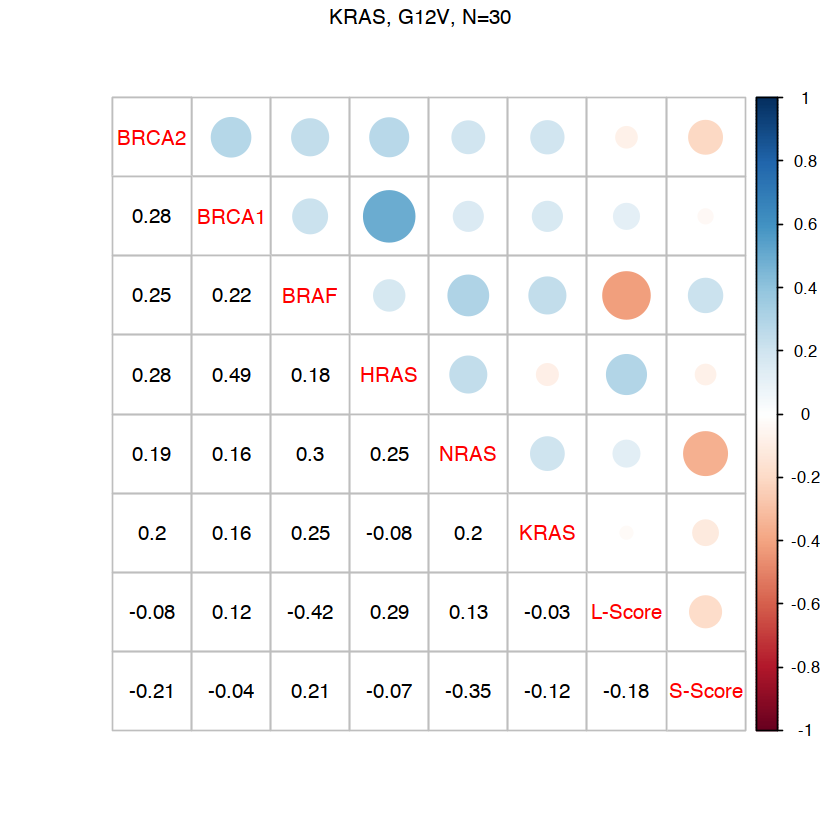

In [53]:
data <- compassResults[which(as.character(compassResults$kras_mut) == "G12V"),]
cor <- cor(data[,c(11,10,9,8,7,6,2,3)], method="spearman")
rownames(cor) <- c("BRCA2", "BRCA1", "BRAF", "HRAS", "NRAS", "KRAS", "L-Score", "S-Score")
colnames(cor) <- c("BRCA2", "BRCA1", "BRAF", "HRAS", "NRAS", "KRAS", "L-Score", "S-Score")
corrplot.mixed(cor, lower.col = "black")
mtext("KRAS, G12V, N=30", side=3, line=3)

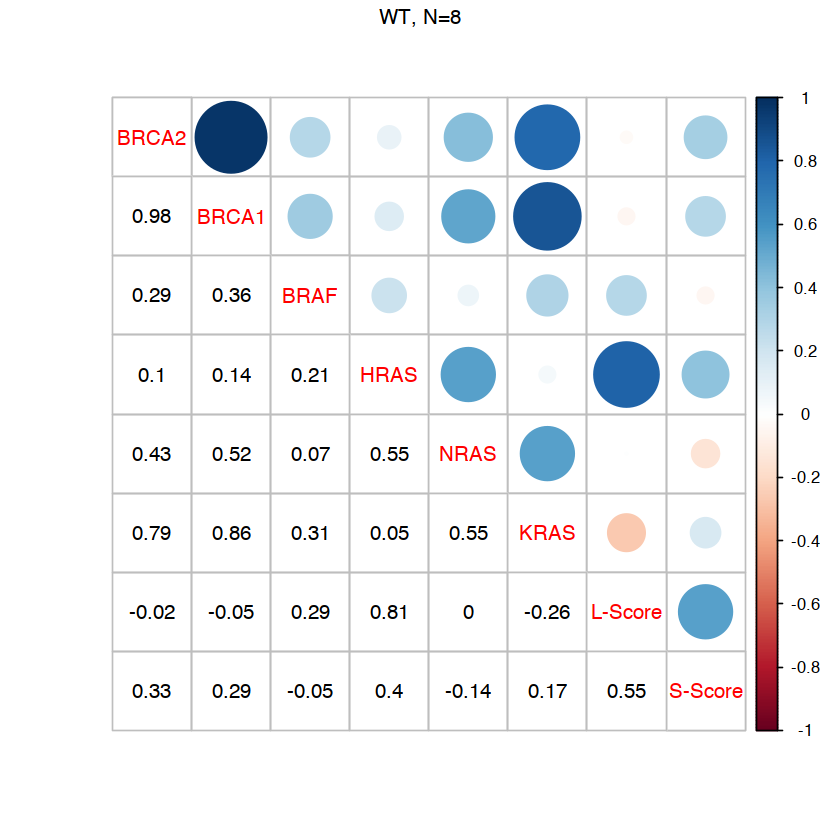

In [54]:
data <- compassResults[which(as.character(compassResults$kras_mut) == "WT"),]
cor <- cor(data[,c(11,10,9,8,7,6,2,3)], method="spearman")
rownames(cor) <- c("BRCA2", "BRCA1", "BRAF", "HRAS", "NRAS", "KRAS", "L-Score", "S-Score")
colnames(cor) <- c("BRCA2", "BRCA1", "BRAF", "HRAS", "NRAS", "KRAS", "L-Score", "S-Score")
corrplot.mixed(cor, lower.col = "black")
mtext("WT, N=8", side=3, line=3)

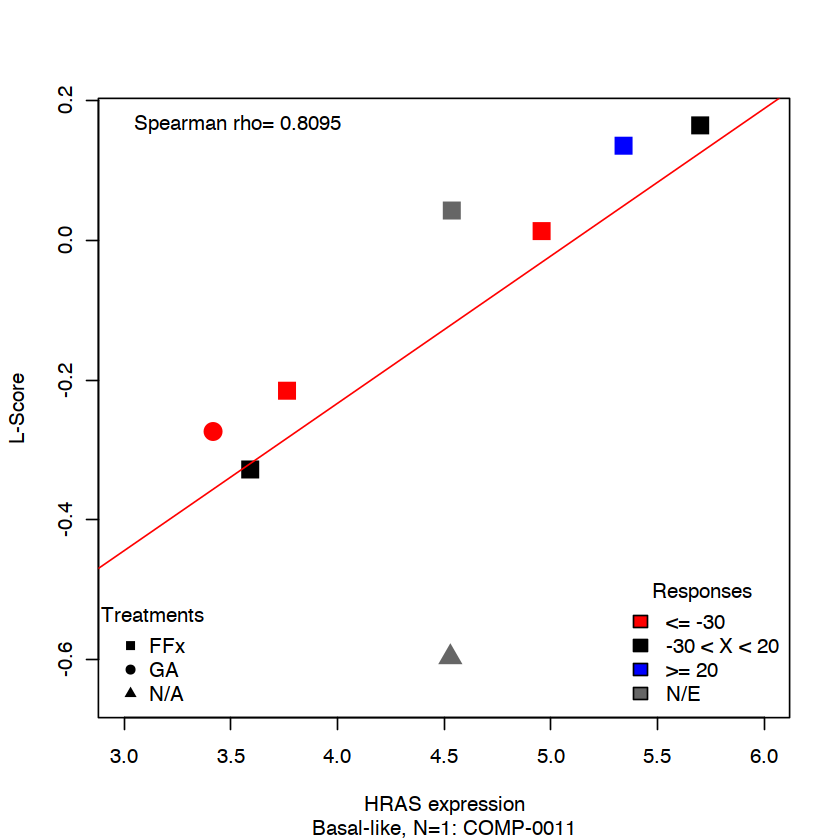

In [55]:
# HRAS exp and L-Score
data <- compassResults[which(as.character(compassResults$kras_mut) == "WT"),]
cor_coef <- cor(data$hras_expr, data$lscore, method="spearman")
plot(data$hras_expr, data$lscore,
    xlim=c(3.0, 6.0), ylim=c(-0.65, 0.17),
    xlab="HRAS expression", ylab="L-Score",
    pch=data$treatments+14, cex=2,
    col=data$responses,
    sub="Basal-like, N=1: COMP-0011")
abline(lm(lscore ~ hras_expr, data=data), col="red")
legend("topleft", legend=c(paste0("Spearman rho= ", format(round(cor_coef, 4), nsmall = 4))), bty="n")
text(data$hras_expr, data$lscore, label=data$Sample, pos=1)
legend("bottomright",
    legend=c("<= -30", "-30 < X < 20", ">= 20", "N/E"),
    fill=c("red", "black", "blue", "grey40"),
    bty="n", title="Responses")
legend("bottomleft",
    legend=c("FFx", "GA", "N/A"),
    pch=c(1,2,3)+14,
    col=c("black", "black", "black"),
    bty="n", title="Treatments")

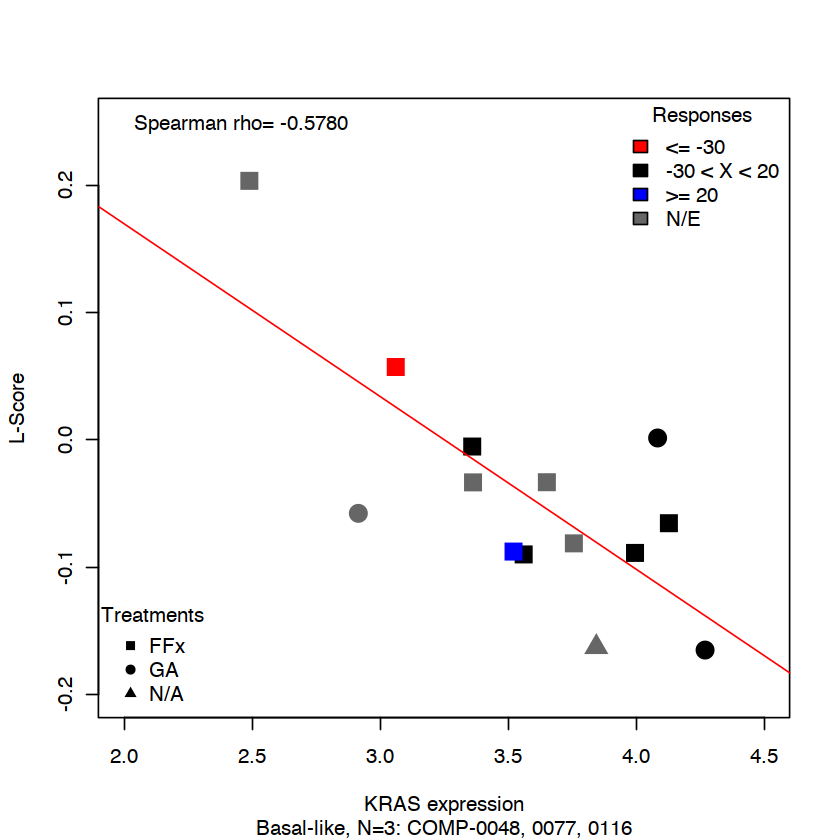

In [56]:
# KRAS exp and L-Score
data <- compassResults[which(as.character(compassResults$kras_mut) == "G12R"),]
cor_coef <- cor(data$kras_expr, data$lscore, method="spearman")
plot(data$kras_expr, data$lscore,
xlim=c(2.0, 4.5), ylim=c(-0.2, 0.25),
    xlab="KRAS expression", ylab="L-Score",
    pch=data$treatments+14, cex=2,
    col=data$responses,
    sub="Basal-like, N=3: COMP-0048, 0077, 0116")
abline(lm(lscore ~ kras_expr, data=data), col="red")
legend("topleft", legend=c(paste0("Spearman rho= ", format(round(cor_coef, 4), nsmall = 4))), bty="n")
text(data$kras_expr, data$lscore, label=data$Sample, pos=1)
legend("topright",
    legend=c("<= -30", "-30 < X < 20", ">= 20", "N/E"),
    fill=c("red", "black", "blue", "grey40"),
    bty="n", title="Responses")
legend("bottomleft",
    legend=c("FFx", "GA", "N/A"),
    pch=c(1,2,3)+14,
    col=c("black", "black", "black"),
    bty="n", title="Treatments")

In [57]:
## By subtype & treatment
ffx_idx <- which(as.character(compassResults$treatments) == 1)
ga_idx <- which(as.character(compassResults$treatments) == 2)
basal_idx <- which(as.character(compassResults$color) == "gold")
classical_idx <- which(as.character(compassResults$color) == "blue")

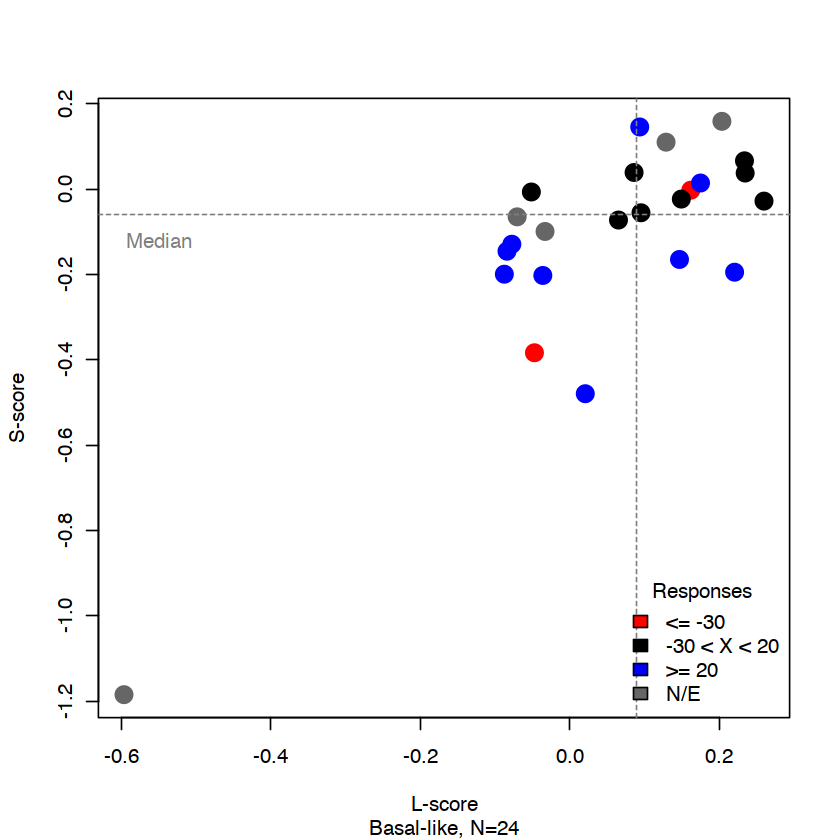

In [58]:
# Basal-like
data <- compassResults[basal_idx,]

plot(data$lscore, data$sscore,
    col=data$responses,
    pch=16, cex=2,
    xlab="L-score", ylab="S-score",
    sub="Basal-like, N=24")
abline(h=median(data$sscore), lty=2, col="grey50")
abline(v=median(data$lscore), lty=2, col="grey50")
legend("bottomright",
    legend=c("<= -30", "-30 < X < 20", ">= 20", "N/E"),
    fill=c("red", "black", "blue", "grey40"),
    bty="n", title="Responses")
text(-0.55, -0.08, label=c("Median"), pos=1, col="grey50")

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


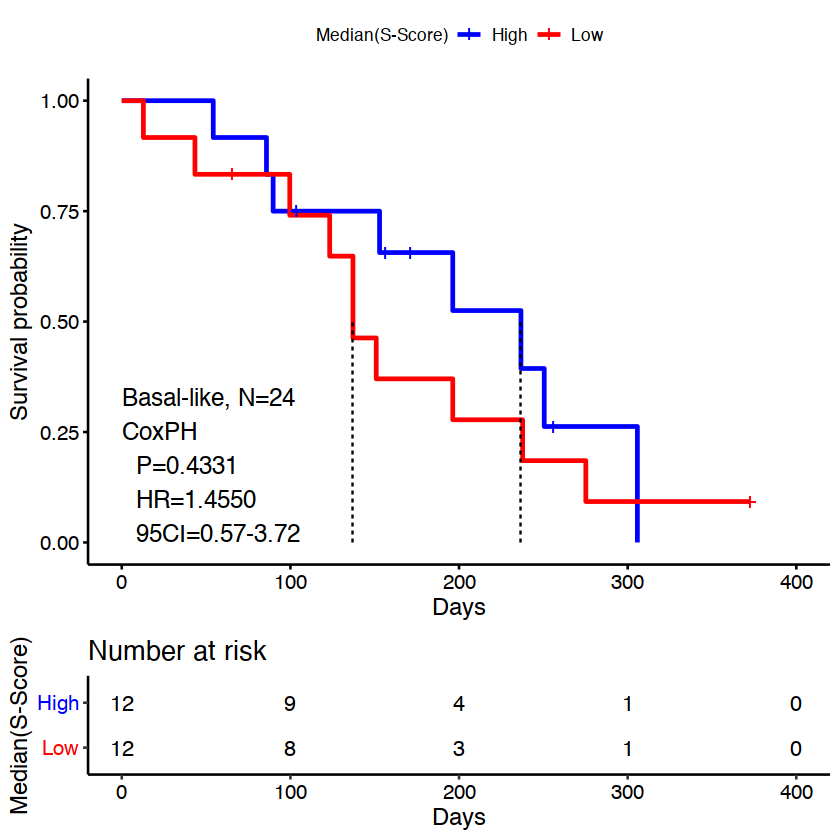

In [59]:
survivalAnalysis(data, "Basal-like", "S-Score")

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


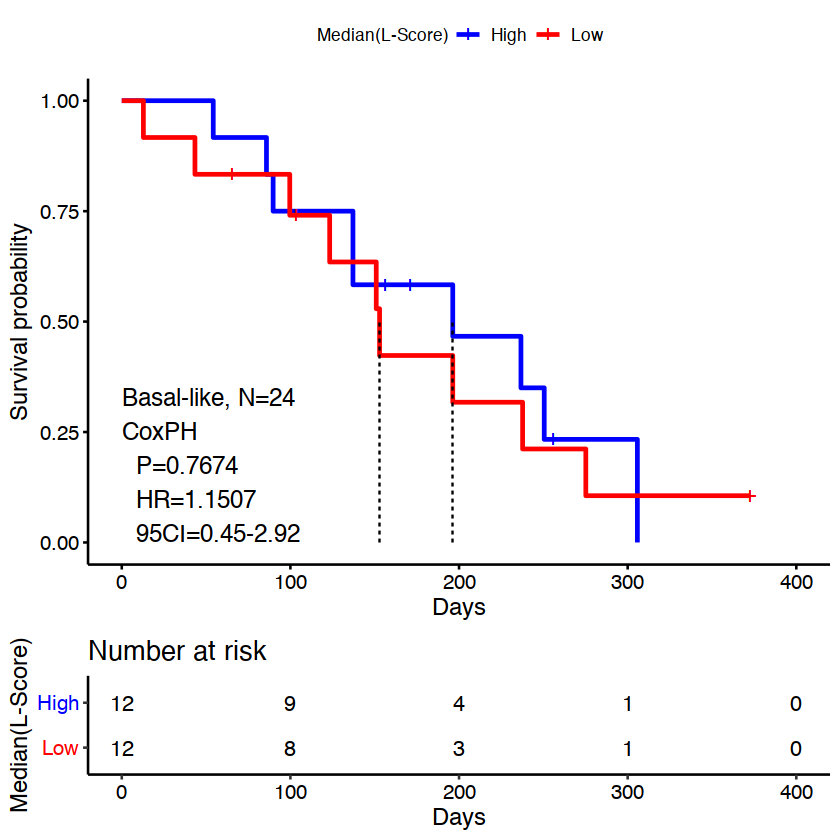

In [60]:
survivalAnalysis(data, "Basal-like", "L-Score")

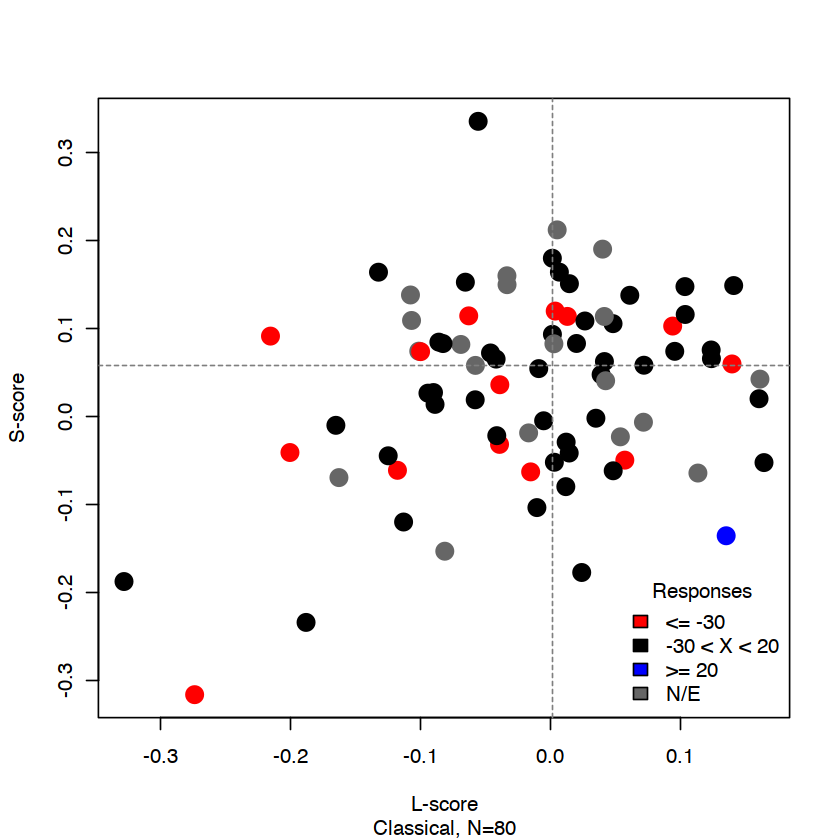

In [61]:
# Classical
data <- compassResults[classical_idx,]

plot(data$lscore, data$sscore,
    col=data$responses,
    pch=16, cex=2,
    xlab="L-score", ylab="S-score",
    sub="Classical, N=80")
abline(h=median(data$sscore), lty=2, col="grey50")
abline(v=median(data$lscore), lty=2, col="grey50")
legend("bottomright",
    legend=c("<= -30", "-30 < X < 20", ">= 20", "N/E"),
    fill=c("red", "black", "blue", "grey40"),
    bty="n", title="Responses")
text(-0.55, -0.08, label=c("Median"), pos=1, col="grey50")

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


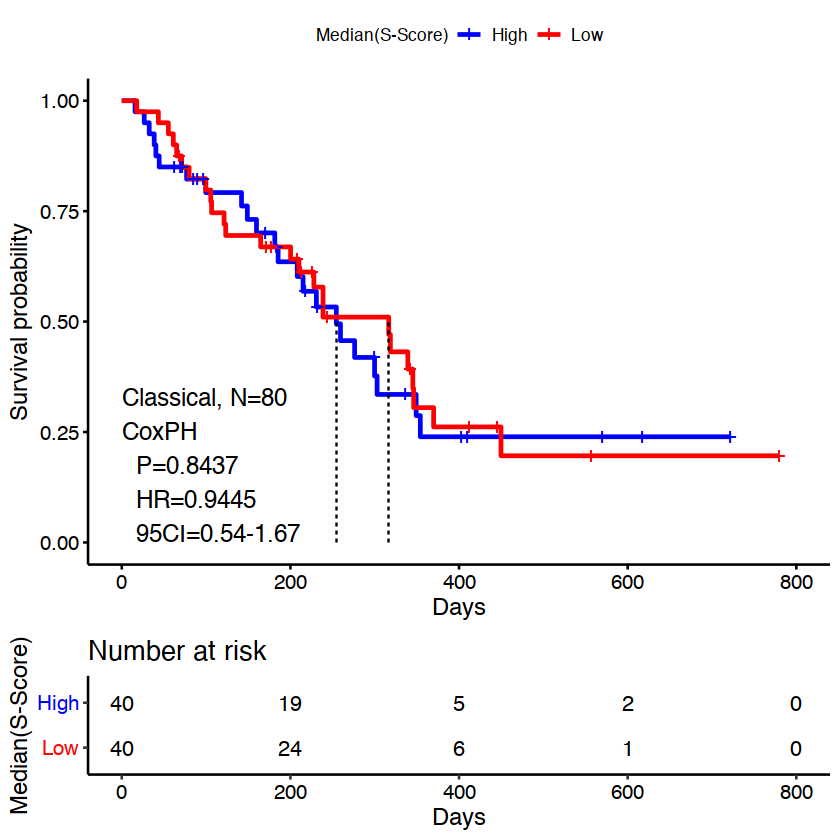

In [62]:
survivalAnalysis(data, "Classical", "S-Score")

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


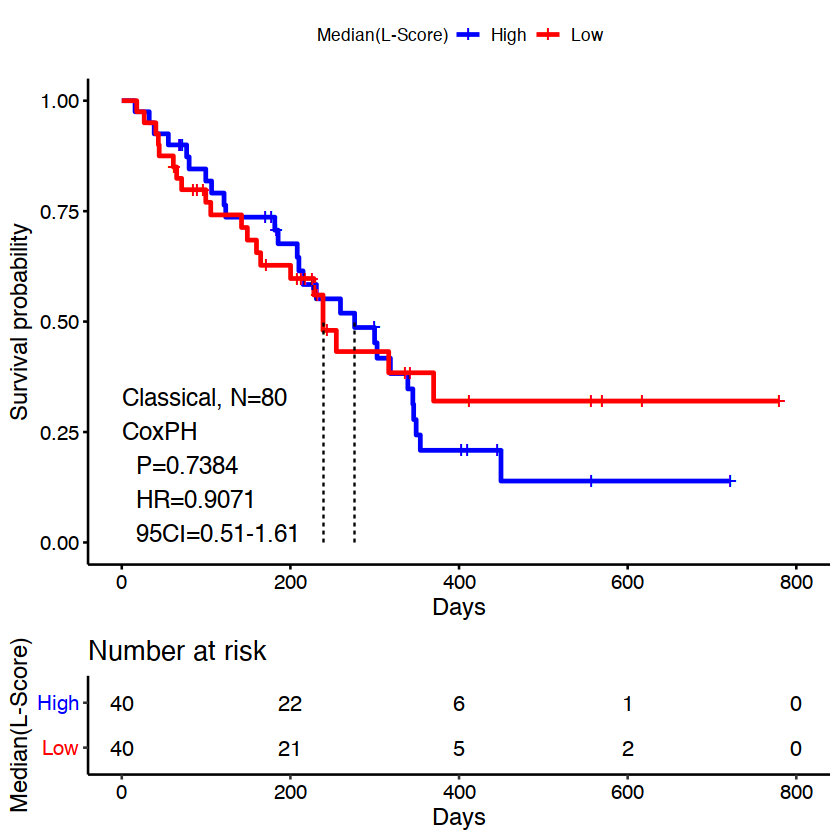

In [63]:
survivalAnalysis(data, "Classical", "L-Score")

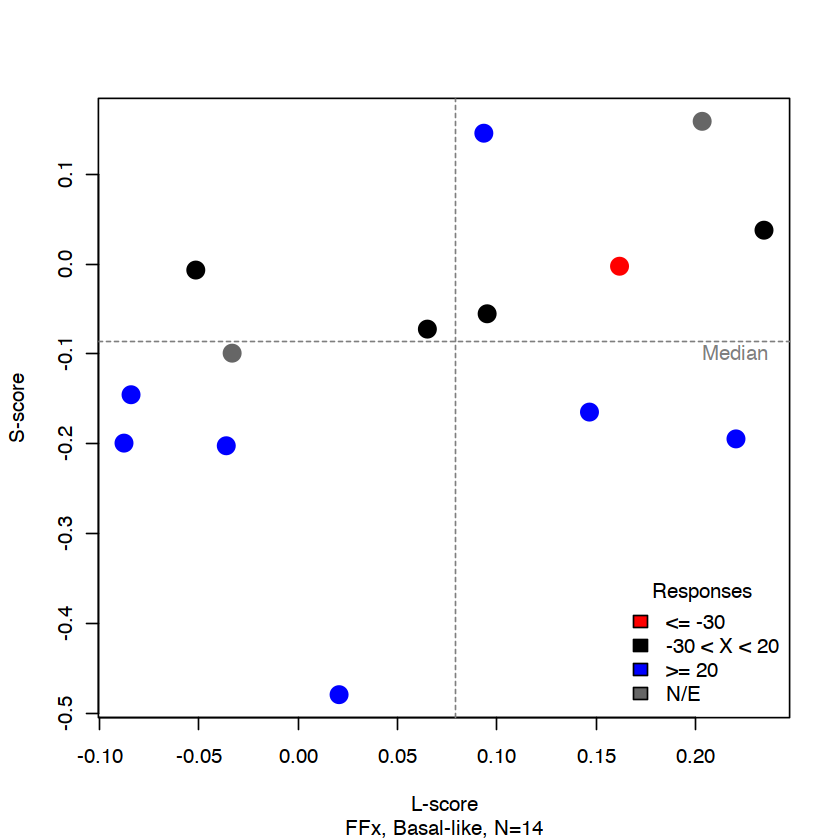

In [64]:
# FFx & Basal-like
data <- compassResults[intersect(ffx_idx, basal_idx),]

plot(data$lscore, data$sscore,
    col=data$responses,
    pch=16, cex=2,
    xlab="L-score", ylab="S-score",
    sub="FFx, Basal-like, N=14")
abline(h=median(data$sscore), lty=2, col="grey50")
abline(v=median(data$lscore), lty=2, col="grey50")
legend("bottomright",
    legend=c("<= -30", "-30 < X < 20", ">= 20", "N/E"),
    fill=c("red", "black", "blue", "grey40"),
    bty="n", title="Responses")
text(0.22, -0.08, label=c("Median"), pos=1, col="grey50")

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


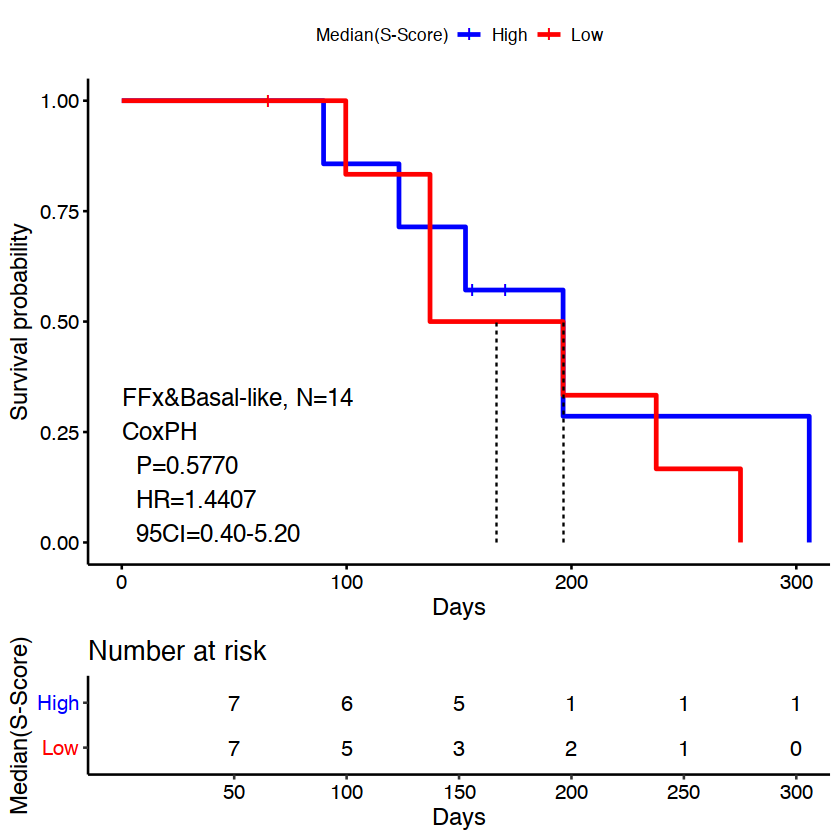

In [65]:
survivalAnalysis(data, "FFx&Basal-like", "S-Score")

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


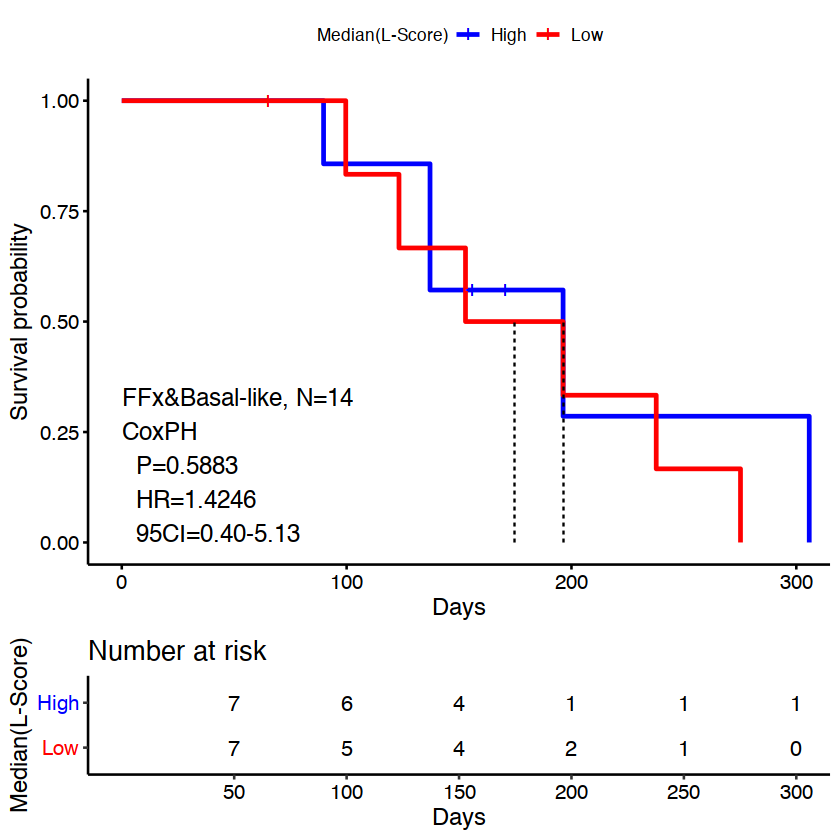

In [66]:
survivalAnalysis(data, "FFx&Basal-like", "L-Score")

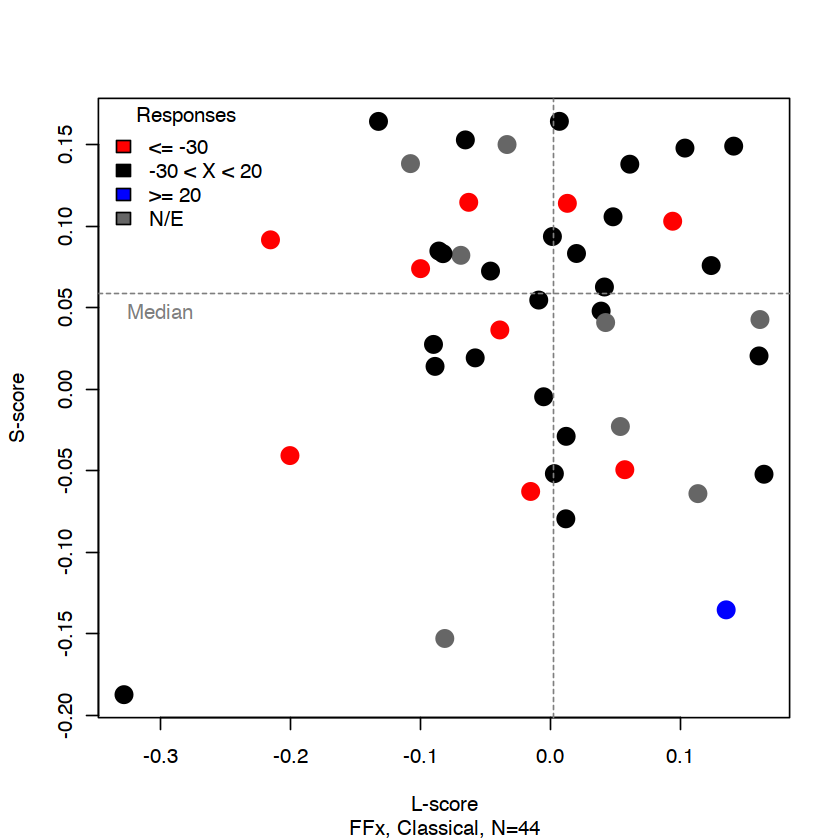

In [67]:
# FFx & Classical
data <- compassResults[intersect(ffx_idx, classical_idx),]

plot(data$lscore, data$sscore,
    col=data$responses,
    pch=16, cex=2,
    xlab="L-score", ylab="S-score",
    sub="FFx, Classical, N=44")
abline(h=median(data$sscore), lty=2, col="grey50")
abline(v=median(data$lscore), lty=2, col="grey50")
legend("topleft",
    legend=c("<= -30", "-30 < X < 20", ">= 20", "N/E"),
    fill=c("red", "black", "blue", "grey40"),
    bty="n", title="Responses")
text(-0.3, 0.058, label=c("Median"), pos=1, col="grey50")

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


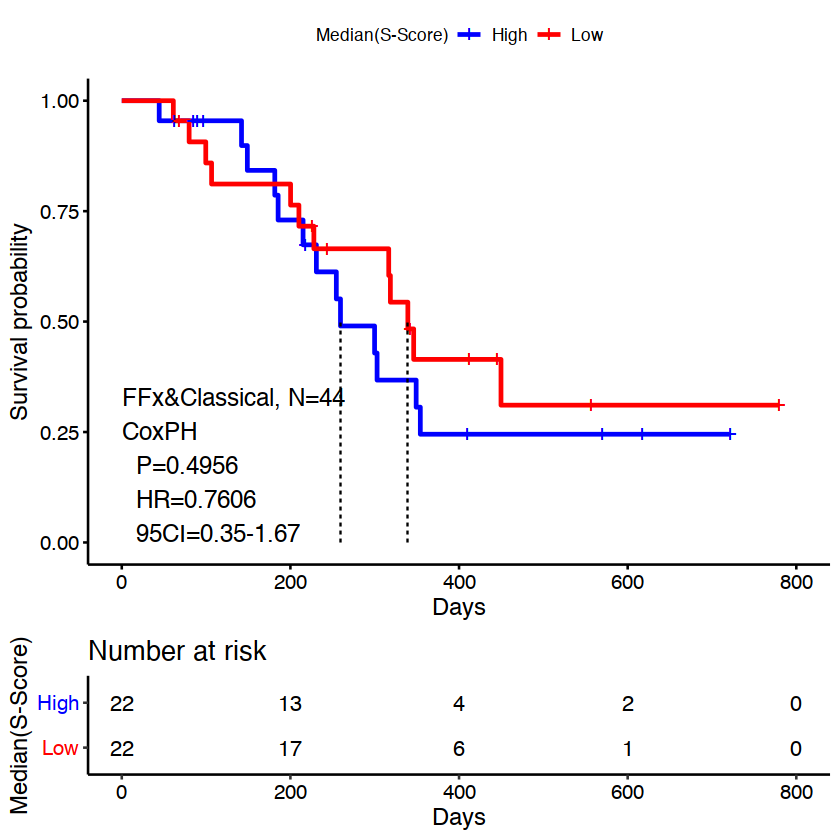

In [68]:
survivalAnalysis(data, "FFx&Classical", "S-Score")

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


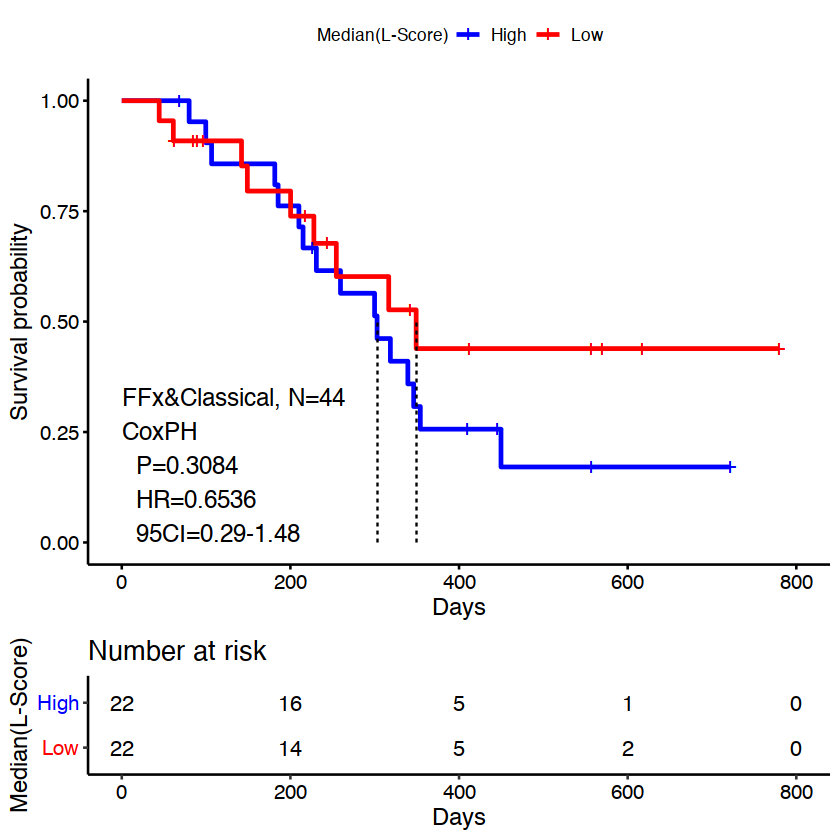

In [69]:
survivalAnalysis(data, "FFx&Classical", "L-Score")

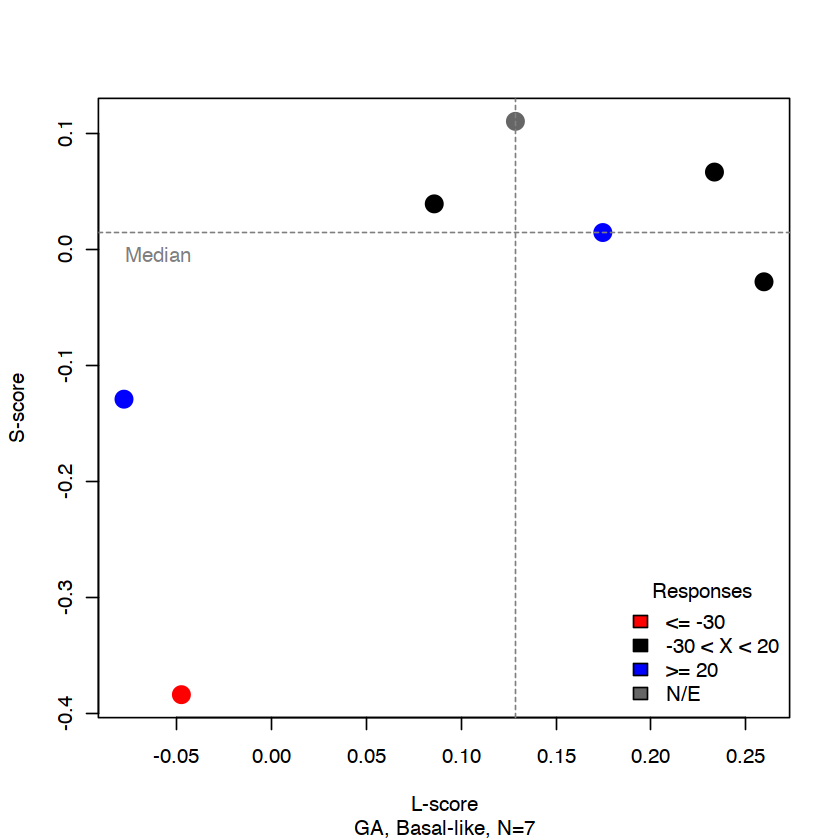

In [70]:
# GA & Basal-like
data <- compassResults[intersect(ga_idx, basal_idx),]

plot(data$lscore, data$sscore,
    col=data$responses,
    pch=16, cex=2,
    xlab="L-score", ylab="S-score",
    sub="GA, Basal-like, N=7")
abline(h=median(data$sscore), lty=2, col="grey50")
abline(v=median(data$lscore), lty=2, col="grey50")
legend("bottomright",
    legend=c("<= -30", "-30 < X < 20", ">= 20", "N/E"),
    fill=c("red", "black", "blue", "grey40"),
    bty="n", title="Responses")
text(-0.06, 0.01, label=c("Median"), pos=1, col="grey50")

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


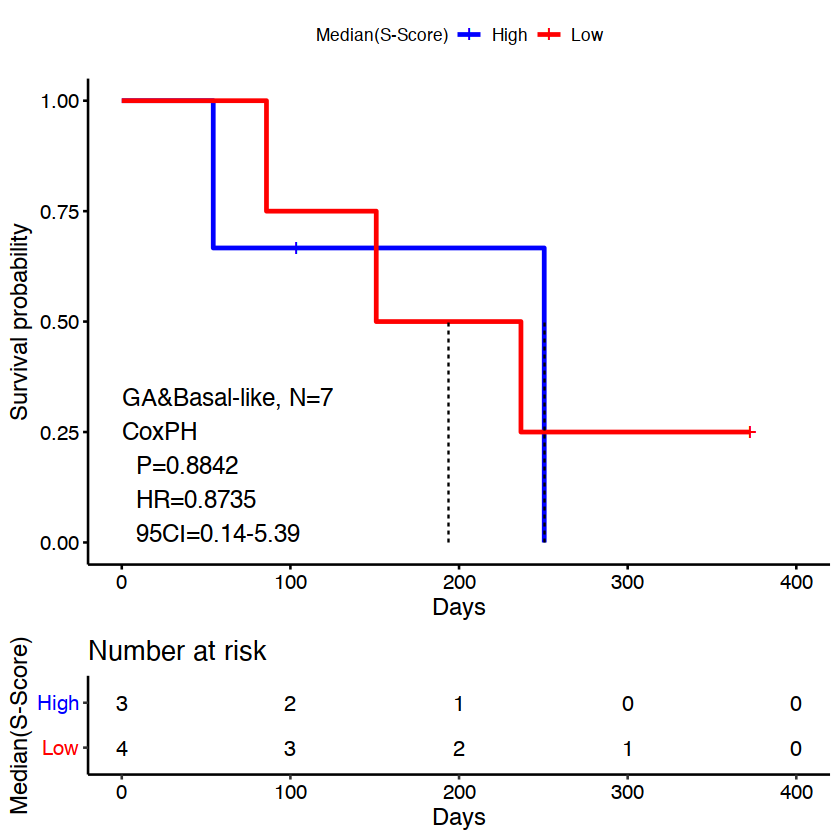

In [71]:
survivalAnalysis(data, "GA&Basal-like", "S-Score")

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


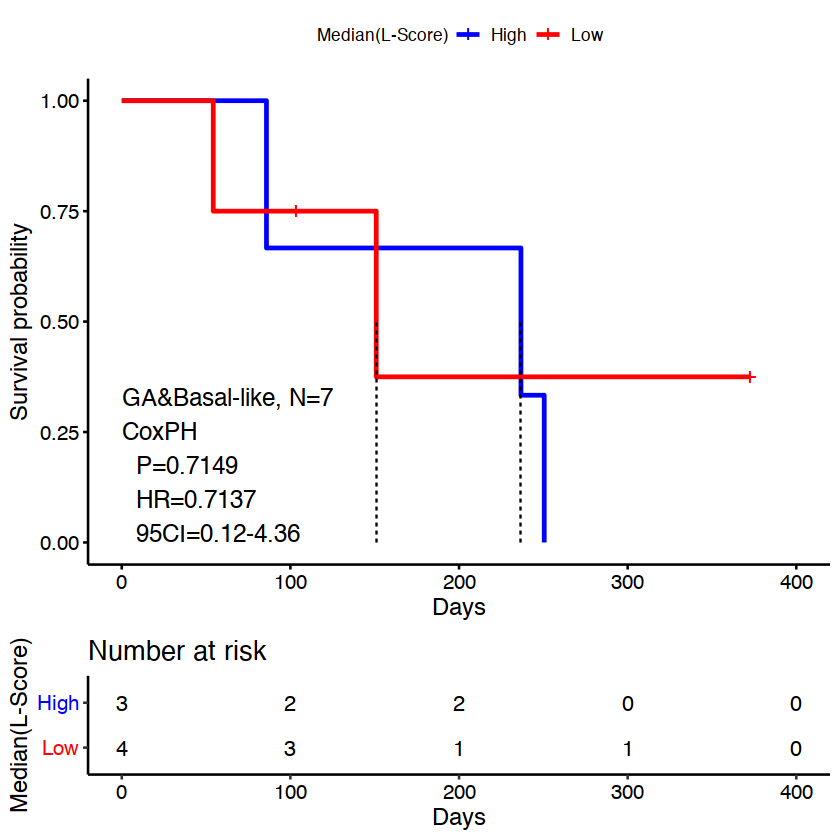

In [72]:
survivalAnalysis(data, "GA&Basal-like", "L-Score")

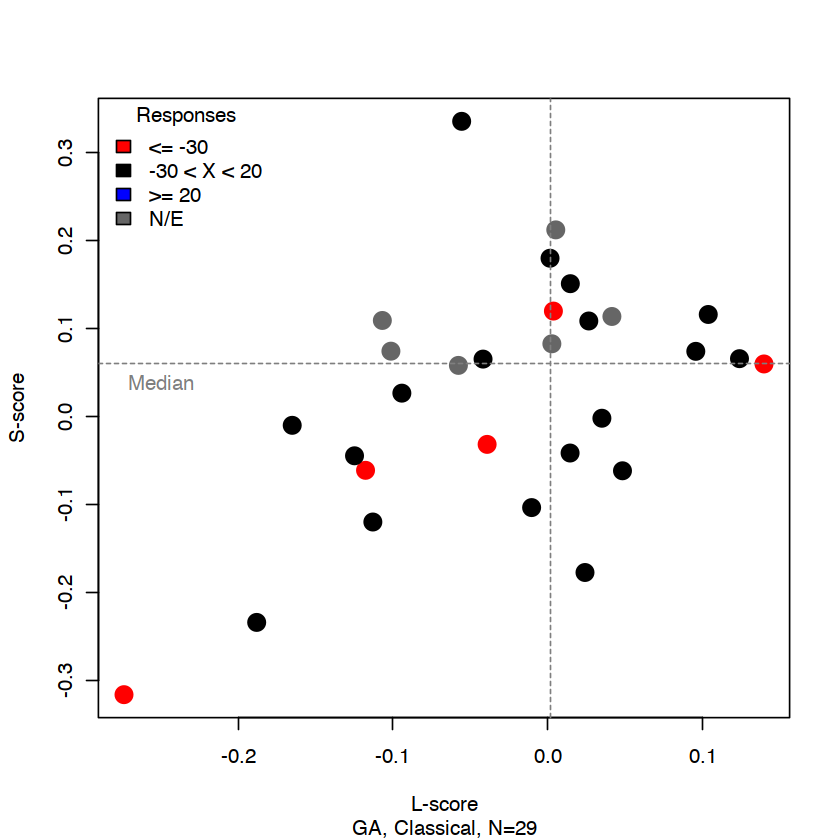

In [73]:
# GA & Classical
data <- compassResults[intersect(ga_idx, classical_idx),]

plot(data$lscore, data$sscore,
    col=data$responses,
    pch=16, cex=2,
    xlab="L-score", ylab="S-score",
    sub="GA, Classical, N=29")
abline(h=median(data$sscore), lty=2, col="grey50")
abline(v=median(data$lscore), lty=2, col="grey50")
legend("topleft",
    legend=c("<= -30", "-30 < X < 20", ">= 20", "N/E"),
    fill=c("red", "black", "blue", "grey40"),
    bty="n", title="Responses")
text(-0.25, 0.058, label=c("Median"), pos=1, col="grey50")

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


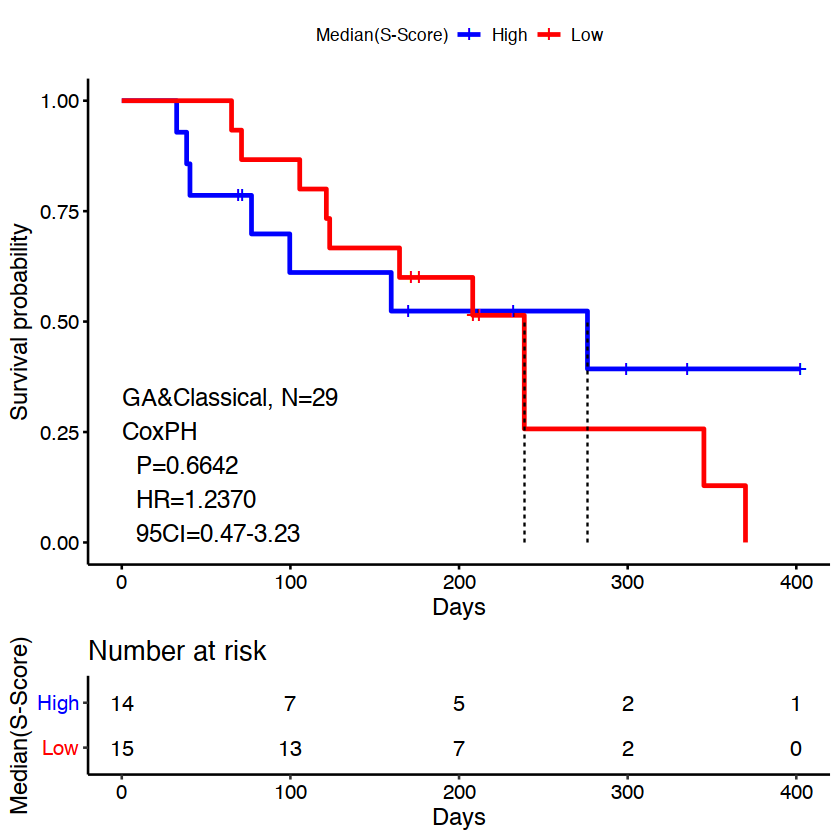

In [74]:
survivalAnalysis(data, "GA&Classical", "S-Score")

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


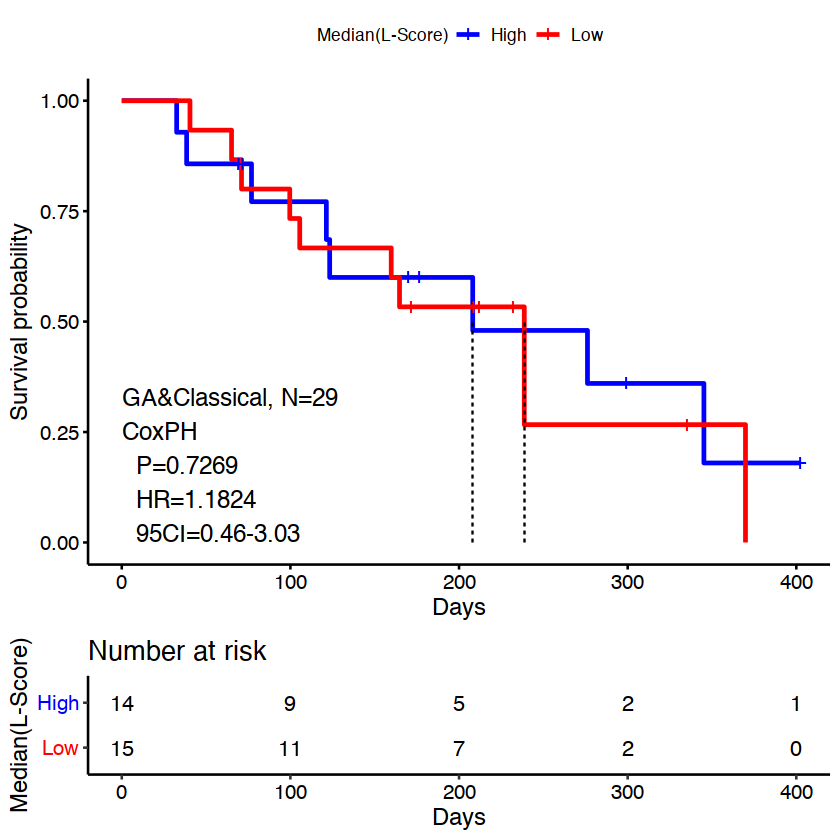

In [75]:
survivalAnalysis(data, "GA&Classical", "L-Score")